# Play with pipeline

### Import

In [6]:
import os
PROJECT_PATH = "/projects/compures/alexandre/disdiff_adapters"
os.chdir(PROJECT_PATH)
print(os.getcwd())

import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils

from PIL import Image, ImageDraw, ImageFont

#DataModule
from disdiff_adapters.data_module import *
#Module
from disdiff_adapters.arch.vae import *
from disdiff_adapters.arch.multi_distillme import *
#utils
from disdiff_adapters.utils import *
#loss
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import *

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import Trainer
from lightning.pytorch.strategies import DDPStrategy

BATCH_SIZE = 128
LATENT_DIM = 128

torch.set_float32_matmul_precision('medium')

/import/pr_compures/alexandre/disdiff_adapters


## Load data 

**Choose the appropriate set :**

### 3DShapes

In [2]:
#6mn30 from ens cluster
shapes = Shapes3DDataModule(batch_size=BATCH_SIZE)
shapes.prepare_data()
shapes.setup(stage='fit')
shapes_loader = shapes.train_dataloader()
# else :
#     images, labels = load_h5(Shapes3D.Path.H5)
#     images = images[:32]
#     labels = labels[:32]
#     shapes_loader = DataLoader(TensorDataset(torch.tensor(images).permute(0,3,1,2), torch.tensor(labels)), batch_size=8, shuffle=True)

loading of tensors - train
loading of tensors - val
load dataset - train
load dataset val
tensors loaded.


In [3]:
print(len(shapes.train_dataset))

307200


In [4]:
for batch in shapes_loader :
    images, labels = batch
    print(images.shape)
    break

torch.Size([128, 3, 64, 64])


### BloodMNIST

In [ ]:
blood = BloodMNISTDataModule(batch_size=BATCH_SIZE)
blood.prepare_data()
blood.setup("fit")
blood_loader = blood.train_dataloader()

: 

In [ ]:
len(blood.train_dataset)

9567

: 

### CelebA

In [ ]:
celeba = CelebADataModule(batch_size=BATCH_SIZE)
celeba.prepare_data()
celeba.setup("fit")
celeba_loader = celeba.train_dataloader()

: 

In [ ]:
len(celeba.train_dataset)

162770

: 

### Choose the correct loader

In [5]:
loader = shapes_loader
stop_at = 0

for i,batch in enumerate(loader) :
    images, labels = batch
    in_channels = images.shape[1]
    img_size = images.shape[2]
    if i == stop_at : break
    
print(f"Data selected with in_channels={in_channels} and img_size={img_size}")
toy_loader = DataLoader(TensorDataset(images, labels), batch_size=BATCH_SIZE)

Data selected with in_channels=3 and img_size=64


## Loss

### KL

### Contrastive

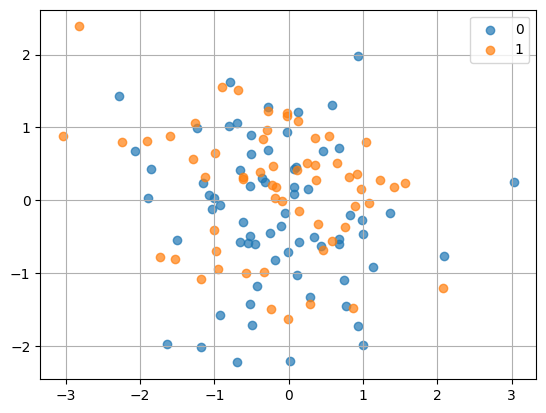

In [11]:
latent_dim_test = 2
pts = torch.randn((BATCH_SIZE, latent_dim_test))
labels = torch.randint(0,2, (BATCH_SIZE,1))
display_latent(labels=labels, z=pts, need_pca=False)

In [ ]:
import torch
import torch.nn as nn
from lightning import LightningModule
import matplotlib.pyplot as plt
import os
import torchvision.utils as vutils
from PIL import Image
import numpy as np

from disdiff_adapters.arch.vae import *
from disdiff_adapters.utils import *
from disdiff_adapters.loss import *


def display_latent(labels: torch.Tensor, 
               mu_logvars: None|tuple[torch.Tensor]=None,
               z: None|torch.Tensor=None, 
               test: bool=False,) :
    """
    Generate a plot to visualize in 2D the latent space.
    Ensure that if z=None, mu_logvars is not None.
    
    Args:
    feats: tuple[torch.Tensor], ((number_sample,latent_dim), (number_sample,latent_dim))
    labels: torch.Tensor, (number_sample, 1)
    z: None|torch.Tensor, (number_sample, latent_dim). Allows to give directly the latent vector. 
    test: bool, if inference set True.
    """
    assert (z is not None and mu_logvars is None) or (z is None and mu_logvars is not None), "Among z and mu_logvars, one should be at None. Both can't be."

    pca = PCA(n_components=2)
    latent = []

    unique_labels = np.unique(labels.detach().cpu().numpy())
    colors = plt.cm.tab10.colors

    label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}
    if z is None :
        z = sample_from(mu_logvars, test=test)

    latent_pca = z.detach().cpu().numpy()
    if not z.shape[1] in [1,2] : latent_pca = pca.fit_transform(latent_pca)

    for label in unique_labels:
        idx = (labels.squeeze(0) == label)
        idx = idx.detach().cpu()
        pts = latent_pca[idx.squeeze(1).cpu()]
        print(labels.shape)
        plt.scatter(pts[:, 0], pts[:, 1],
                    color=label_to_color[label], label=label, alpha=0.7)
        plt.legend()
    plt.grid()
    plt.show()



class _MultiDistillMe(torch.nn.Module) : 
    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim_s: int,
                 latent_dim_t: int,
                 res_block: nn.Module=ResidualBlock) :
        
        super().__init__()

        self.encoder_s = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim_s,
                                 res_block=res_block)
        
        self.encoder_t = Encoder(in_channels=in_channels, 
                                 img_size=img_size,
                                 latent_dim=latent_dim_t,
                                 res_block=res_block)
        
        self.merge_operation = lambda z_s, z_t : torch.cat([z_s, z_t], dim=1)

        self.decoder = Decoder(out_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim_s+latent_dim_t,
                               res_block=res_block,
                               out_encoder_shape=self.encoder_s.out_encoder_shape)
        
        self.labels_buff = []
        self.latent_buff = []
        
    def forward(self, images: torch.Tensor) :

        #forward s - semble encoder la couleur
        mus_logvars_s = self.encoder_s(images)
        z_s = sample_from(mus_logvars_s)

        #forward_t - semble encoder la forme
        mus_logvars_t = self.encoder_t(images)
        z_t = sample_from(mus_logvars_t)

        #merge latent vector from s and t
        z = self.merge_operation(z_s, z_t)

        #decoder
        image_hat_logits = self.decoder(z)

        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
class MultiDistillMeModule(LightningModule) :

    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim_s: int,
                 latent_dim_t: int,
                 res_block: nn.Module=ResidualBlock,
                 beta_s: float=1.0,
                 beta_t: float=1.0,
                 warm_up:bool =False,
                 kl_weight: float= 10e-4,
                 l_cov: float=1,
                 l_nce: float=1,
                 l_anti_nce: float=1,) :
        
        super().__init__()
        self.save_hyperparameters()

        self.model = _MultiDistillMe(in_channels=self.hparams.in_channels,
                                     img_size=self.hparams.img_size,
                                     latent_dim_s=self.hparams.latent_dim_s,
                                     latent_dim_t=self.hparams.latent_dim_t,
                                     res_block=self.hparams.res_block)
            

        self.images_test_buff = None
        self.images_train_buff = None
        self.z_ref = None
        self.constrastive = MultiClassSupConLoss(temperature=1e-2)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters())
    
    def generate(self, nb_samples: int=16) :
        eps_s = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim_s])).to(self.device, torch.float32)
        eps_t = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim_t])).to(self.device, torch.float32)


        z = self.model.merge_operation(eps_s, eps_t)

        x_hat_logits = self.model.decoder(z)
        return x_hat_logits

    def generate_cond(self, nb_samples: int=16, cond: str="t", pos: int=0) :
        if cond == "t" :
            eps_t = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim_t])).to(self.device, torch.float32)
            z_s = torch.stack(nb_samples*[self.z_ref["s"][pos]])
            z = self.model.merge_operation(z_s, eps_t)
        elif cond == "s" :
            eps_s = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim_s])).to(self.device, torch.float32)
            z_t = torch.stack(nb_samples*[self.z_ref["t"][pos]])
            z = self.model.merge_operation(eps_s, z_t)
        else : raise ValueError("cond has to be equal to ")

        x_hat_logits = self.model.decoder(z)
        return x_hat_logits

    def show_reconstruct(self, images: torch.Tensor) :
        images = images.to(self.device)[:8]
        mus_logvars_s, mus_logvars_t, images_gen, z_s, z_t, z = self(images, test=True)

        fig, axes = plt.subplots(len(images), 2, figsize=(7, 20))

        for i in range(len(images)) :
            img = images[i]
            img_gen = images_gen[i]

            images_proc = (255*((img - img.min()) / (img.max() - img.min() + 1e-8))).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()
            images_gen_proc = (255*((img_gen - img_gen.min()) / (img_gen.max() - img_gen.min() + 1e-8))).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()

            axes[i,0].imshow(images_proc)
            axes[i,1].imshow(images_gen_proc)

            axes[i,0].set_title("original")
            axes[i,1].set_title("reco")
        plt.tight_layout()
        plt.show()
        return mus_logvars_s, mus_logvars_t, images_gen, z_s, z_t, z

    def forward(self, images: torch.Tensor, test=False) :
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.model(images)
        return mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z
    
    def loss(self, mus_logvars_s: torch.Tensor, 
             mus_logvars_t: torch.Tensor, 
             image_hat_logits: torch.Tensor, 
             images: torch.Tensor, 
             z_s: torch.Tensor,
             z_t: torch.Tensor,
             labels=None, 
             log_components: bool=False) :

        weighted_kl_s = self.hparams.kl_weight*self.hparams.beta_s*kl(*mus_logvars_s)
        weighted_kl_t = self.hparams.kl_weight*self.hparams.beta_t*kl(*mus_logvars_t)
        reco = mse(image_hat_logits, images)
        #cross_cov = decorrelate_params(*mus_logvars_s, *mus_logvars_t, l_var=0)/(self.hparams.latent_dim_s*self.hparams.latent_dim_t)
        #nce = self.constrastive(z_t, labels)

        
        if log_components :
            self.log("loss/kl_s", weighted_kl_s)
            self.log("loss/kl_t", weighted_kl_t)
            self.log("loss/reco", reco)
            #self.log("loss/cov", cross_cov)
            #self.log("loss/nce", nce)

        #loss_value = weighted_kl_t+weighted_kl_s+reco+self.hparams.l_cov*cross_cov+self.hparams.l_nce*nce
        loss_value = weighted_kl_t+weighted_kl_s+reco
        return loss_value
    
    def training_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        print(labels.shape)
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits, images, z_s, z_t, 
                         labels=labels[:, 0], log_components=True)

        print(f"Train loss: {loss}")
        
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        self.log("loss/train", loss)

        if self.images_train_buff is None : 
            self.images_train_buff = images
            self.labels_train_buff = labels
            self.z_ref = {"s":z_s, "t": z_t}

        return loss

    def validation_step(self, batch: tuple[torch.Tensor]):
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images)
        loss = self.loss(mus_logvars_s, mus_logvars_t, image_hat_logits, images, z_s, z_t, labels=labels[:, 0])

        self.log("loss/val", loss)
        print(f"Val loss: {loss}")
    
    def test_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = self.forward(images, test=True)

        weighted_kl_s = self.hparams.beta_s*kl(*mus_logvars_s)
        weighted_kl_t = self.hparams.beta_t*kl(*mus_logvars_t)
        reco = mse(image_hat_logits, images)

        self.log("loss/reco_test", reco)
        self.log("loss/kl_s_test", weighted_kl_s)
        self.log("loss/kl_t_test", weighted_kl_t)
        self.log("loss/test", reco+weighted_kl_t+weighted_kl_s)

        if self.images_test_buff is None : self.images_test_buff = images

    def on_train_epoch_end(self):
        epoch = self.current_epoch

        if epoch % 5 == 0:
            # try : os.mkdir(os.path.join(self.logger.log_dir, f"epoch_{epoch}"))
            # except FileExistsError as e : pass

            mus_logvars_s, mus_logvars_t, images_gen, z_s, z_t, z = self.show_reconstruct(self.images_train_buff) #display images and reconstruction in interactive mode; save the plot in plt.gcf() if non interactive
            # #save the recontruction plot saved in plt.gcf()
            # save_reco_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"reco_{epoch}.png")
            # plt.gcf().savefig(save_reco_path)

            # self.log_gen_images()

            # ### heatmap
            # path_heatmap = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"cov_{epoch}.png")
            # log_cross_cov_heatmap(*mus_logvars_s, *mus_logvars_t, path_heatmap)

            ### latent space
            labels = self.labels_train_buff
            print(labels[:, 0].unsqueeze(1).shape, z_s.shape)

            display_latent(labels=labels[:, 0].unsqueeze(1), z=self.z_ref["s"])
            plt.gcf().savefig("z_s.png")
            display_latent(labels=labels[:, 0].unsqueeze(1), z=self.z_ref["t"])
            plt.gcf().savefig("z_t.png")
            latent_img = merge_images_with_black_gap(["z_s.png", "z_t.png"])
            latent_img.save("latent_space.png")
            os.remove("z_s.png")
            os.remove("z_t.png")

        self.images_train_buff = None
        self.labels_train_buff = None
        self.z_ref = None

    def on_test_end(self):
        images_gen = self.generate()
        labels_gen = torch.zeros([images_gen.shape[0],1])

        display((images_gen.detach().cpu(), labels_gen.detach().to("cpu")))

        self.logger.experiment.add_figure("img/gen", plt.gcf())

        self.show_reconstruct(self.images_test_buff)
        self.logger.experiment.add_figure("img/reco", plt.gcf())

        vutils.save_image(images_gen.detach().cpu(), os.path.join(self.logger.log_dir, "gen.png"))

    def log_gen_images(self) :
        epoch = self.current_epoch

        #save the generate images
        images_gen = self.generate()
        save_gen_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_{epoch}.png")
        vutils.save_image(images_gen.detach().cpu(), save_gen_path)
            
        #save the cond generate image s
        for i in range(4) :
            images_cond_s_gen = self.generate_cond(cond="s", pos=i)
            images_cond_s_gen_ref = torch.cat([images_cond_s_gen.detach().cpu(), self.images_train_buff[i].detach().cpu().unsqueeze(0)])
            save_gen_s_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_s_{epoch}_{i}.png")
            vutils.save_image(images_cond_s_gen_ref, save_gen_s_path)

        #save the cond generate image t
        for i in range(4) :
            images_cond_t_gen = self.generate_cond(cond="t")
            images_cond_t_gen_ref = torch.cat([images_cond_t_gen.detach().cpu(), self.images_train_buff[i].detach().cpu().unsqueeze(0)])
            save_gen_t_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_t_{epoch}_{i}.png")
            vutils.save_image(images_cond_t_gen_ref.detach().cpu(), save_gen_t_path)

        ### Merge in one image
        final_gen_s = merge_images_with_black_gap(
                                    [ os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_s_{epoch}_{i}.png") for i in range(4)]
                                    )
        final_gen_t = merge_images_with_black_gap(
                        [ os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_t_{epoch}_{i}.png") for i in range(4)]
                        )
        final_gen_s.save("final_gen_s.png")
        final_gen_t.save("final_gen_t.png")
        final_image = merge_images(save_gen_path, "final_gen_s.png", "final_gen_t.png")
        save_gen_all_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_all_{epoch}.png")
        final_image.save(save_gen_all_path)

        os.remove("final_gen_s.png")
        os.remove("final_gen_t.png")
        for i in range(4) : 
            os.remove(os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_s_{epoch}_{i}.png"))
            os.remove(os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_t_{epoch}_{i}.png"))


torch.Size([128, 6])


/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Train loss: 0.2323242425918579


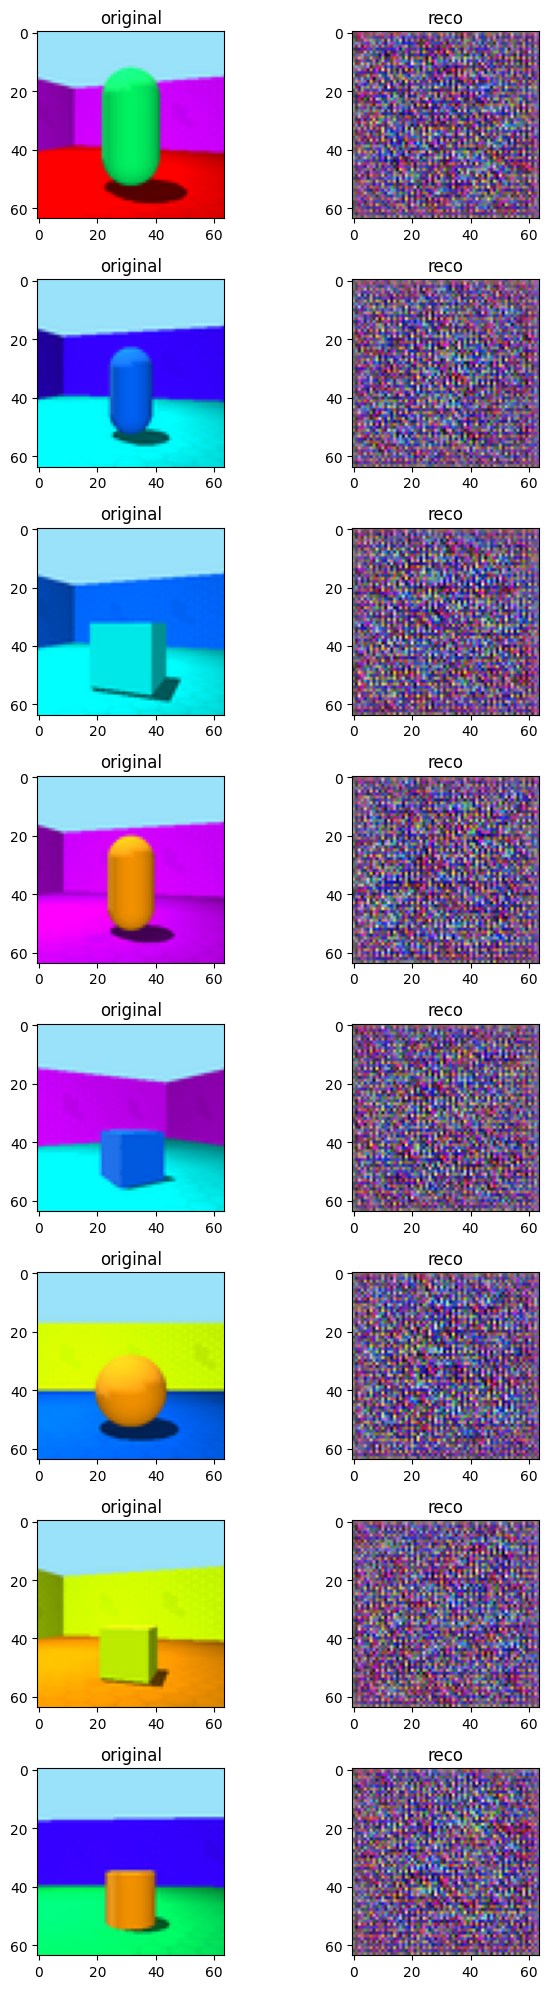

torch.Size([128, 1]) torch.Size([8, 126])
labels.shape = torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


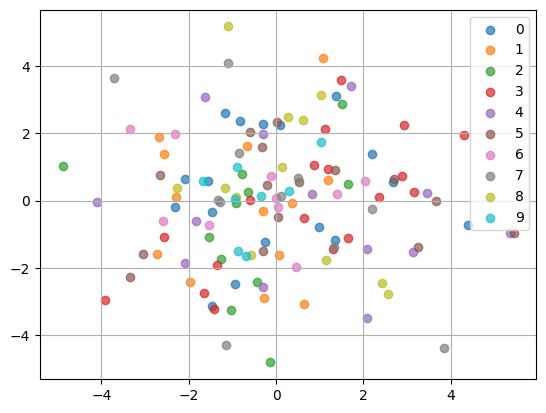

labels.shape = torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


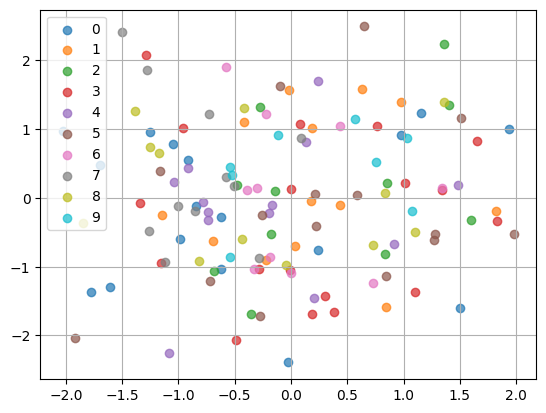

<Figure size 640x480 with 0 Axes>

In [13]:
md = MultiDistillMeModule(in_channels=3,
              img_size=64,
              latent_dim_s=126,
              latent_dim_t=2)

md.training_step(batch)
md.on_train_epoch_end()

In [ ]:
md = _MultiDistillMe(in_channels=3,
              img_size=64,
              latent_dim_s=126,
              latent_dim_t=2)

criterion = MultiClassSupConLoss(temperature=3e-3)
optim = torch.optim.SGD(md.parameters())

for epoch in range(1) :

    total_loss = 0.0
    for batch in shapes_loader :
        images, labels = batch
        optim.zero_grad()
        #mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z = md(images)
        mus_logvars_s, mus_logvars_t, image_hat_logits, z_s, z_t, z=md(images)

        loss = criterion(z_t, labels[:, 0])+kl(*mus_logvars_s)+kl(*mus_logvars_t)

        loss.backward()
        optim.step()
        total_loss+=loss.item()
    print(total_loss)

    if not epoch%5 : 
        display_latent(labels[:,0].unsqueeze(1), z=z_s)
        display_latent(labels[:, 0].unsqueeze(1), z=z_t)

KeyboardInterrupt: 

### Cross covariance

## VAE

### Variational Encoder

Let's display the PCA-latent space with VAE encoder

In [6]:
encoder = Encoder(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM)

encoder.eval()
mus = []
logvars = []
labels = []

for i,batch in enumerate(loader) :
    image, label = batch

    mu, logvar = encoder(image)

    mus.append(mu)
    logvars.append(logvar)
    labels.append(label)
    if (stop_at is not None) and (stop_at == i) : break

try :
    mus = torch.cat(mus)
    logvars = torch.cat(logvars)
    labels = torch.cat(labels)
except TypeError as e : print("!!You have already run this cell.!!")
print(f"labels shape = {labels.shape}")

labels shape = torch.Size([128, 6])


Make sure that labels shape is at [Batch size, 1]. Preprocess here if needed :

In [7]:
labels[:, 0].unsqueeze(1).shape

torch.Size([128, 1])

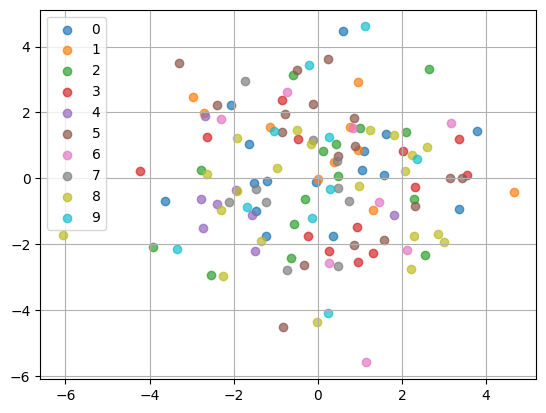

In [10]:
assert labels[:, 0].unsqueeze(1).shape == (labels.shape[0], 1), "You have to preprocess labels before using pca_latent display function"
display_latent(labels=labels[:, 0].unsqueeze(1), mu_logvars=(mus, logvars))

In [ ]:
print(encoder.flattened_size, encoder.out_encoder_shape)

4096 torch.Size([256, 4, 4])


: 

### Decoder

In [ ]:
#Sample latent
z = sample_from((mus, logvars))
print(f"Latent space is a {z.shape}")
decoder = Decoder(out_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, out_encoder_shape=encoder.out_encoder_shape)
x_hat_logits = decoder(z)
try: assert x_hat_logits.shape == (x_hat_logits.shape[0], in_channels, img_size, img_size)
except AssertionError as e : 
    print(x_hat_logits.shape)
    print("!!!!WARNING : reconstruction error : output of the decoder must be with the a same shape as the input")


KeyboardInterrupt



: 

In [ ]:
x_hat_logits.shape

torch.Size([128, 3, 28, 28])

: 

tensor(-0.9677, grad_fn=<MinBackward1>) tensor(0.9706, grad_fn=<MaxBackward1>)


IndexError: index 11 is out of bounds for axis 0 with size 11

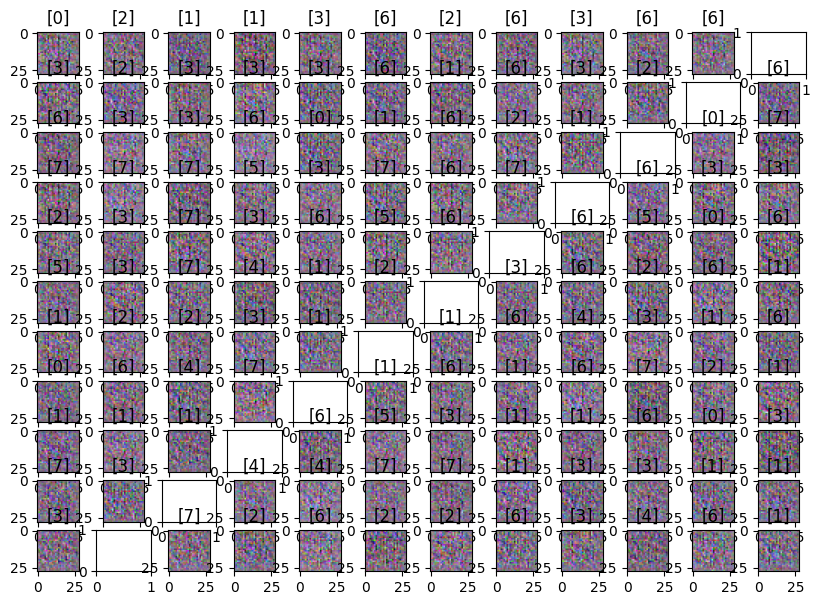

: 

In [ ]:
assert x_hat_logits.shape==image.shape, "shape error"
print(x_hat_logits.min(), x_hat_logits.max())
display((x_hat_logits, labels[:, 0].unsqueeze(1)))
loss_mse = mse(x_hat_logits, image)
loss_kl = kl(*(mus, logvars))

### VAE - train

In [ ]:
print(images.shape)
print(images.min(), images.max())

torch.Size([128, 3, 64, 64])
tensor(0.) tensor(1.)


: 

In [ ]:
import torch
import torch.nn as nn
from lightning import LightningModule

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.relu(out)
        return out
    
class SimpleConv(nn.Module) :
    def __init__ (self, in_channels: int, out_channels: int) :
        super(SimpleConv, self).__init__()
        self.conv = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), 
                                nn.BatchNorm2d(out_channels), 
                                nn.LeakyReLU())
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels: int, img_size: int, latent_dim: int, is_vae=True):
        """
        Load a variational encoder.

        Args:
            in_channels: int, channel of the original image
            img_size: int, for a 28x28px img_size=28
            latent_dim: int, size of a latent vector
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.out_encoder_shape = None
        self.is_vae=is_vae
        self.activation = nn.LeakyReLU
        self.res_block = SimpleConv

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 48, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(48), self.activation(), #/2
            self.res_block(48, 48),
            nn.Conv2d(48, 96, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(96), self.activation(), #/2
            self.res_block(96, 96),
            nn.Conv2d(96, 192, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(192), self.activation(), #/2
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1), self.activation() #/1
        )

        # calcul automatique de la taille aplatie après convolutions
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_size, img_size)
            out = self.features(dummy)
            self.out_encoder_shape = out.shape[1:]
            self.flattened_size = out.shape[1]*out.shape[2]*out.shape[3]
        if is_vae:
            self.fc = nn.Sequential(nn.Flatten(),nn.Linear(self.flattened_size, latent_dim * 2))

    def forward(self, x):
        x = self.features(x)
        if self.is_vae :
            x = self.fc(x)
            mu, logvar = torch.chunk(x, 2, dim=1)
            return mu, logvar
        else : return x


import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    """
    VAE Decoder.
    
    See VAE docstring.

    ConvTranspose2D double H,W with kernel=4, stride=2, padding=1
    """
    
    def __init__(self, out_channels: int, 
                 img_size: int, 
                 latent_dim: int, 
                 out_encoder_shape: tuple[int],
                 is_vae: bool=True):
        """
        Load a decoder variational.

        Args:
            latent_dim: int, size of the input latent vector.
            out_shape: tuple[int], (C,H,W) shape of the output image
            out_encoder_shape: tuple[int], (C,H,W) shape of the last convolutional layer of the encoder.
        """

        super().__init__()
        self.img_size = img_size
        self.out_channels = out_channels
        self.out_encoder_shape = out_encoder_shape
        self.is_vae = is_vae
        self.activation = nn.LeakyReLU
        self.res_block = SimpleConv

        C,H,W = self.out_encoder_shape

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, C*W*H), 
            nn.Unflatten(1, (C, W, H)),)
    
        self.net = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1), #*1
            nn.BatchNorm2d(192),
            self.activation(),

            nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1), #*2
            nn.BatchNorm2d(96),
            self.activation(),

            self.res_block(96, 96),

            nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1),#*2
            nn.BatchNorm2d(48),
            self.activation(),

            self.res_block(48, 48),
 
            nn.ConvTranspose2d(48, self.out_channels, kernel_size=4, stride=2, padding=1), #*2
            self.activation(self.out_channels, self.out_channels),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1), #*1
        )

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_vae : x = self.fc(x)

        x = self.net(x)
        if not (self.img_size > 0 and (self.img_size & (self.img_size - 1))) == 0 : 

            x = F.interpolate(x, 
                              size=(self.img_size, self.img_size), 
                              mode='bilinear', 
                              align_corners=False) #Padding
        activation = nn.Sigmoid()
        return activation(x)


class _VAE(torch.nn.Module) :
    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int) :
        
        super().__init__()

        self.encoder = Encoder(in_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,)
        
        self.decoder = Decoder(out_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,
                               out_encoder_shape=self.encoder.out_encoder_shape)
        
    def forward(self, images: torch.Tensor, test: bool=False) :
        mus_logvars = self.encoder(images)
        z = sample_from(mus_logvars, test)
        image_hat_logits = self.decoder(z)

        return image_hat_logits, mus_logvars

class VAEModule(LightningModule) :

    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int,
                 beta: float=1.0,
                 warm_up: bool=False,
                 kl_weights: float= 1e-5,
                 lr: float=6e-5) :
        
        super().__init__()
        self.save_hyperparameters()

        self.model = _VAE(in_channels=self.hparams.in_channels,
                          img_size=self.hparams.img_size,
                          latent_dim=self.hparams.latent_dim)
        self.images_test_buff = None
        self.images_train_buff = None
    
            
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.lr, weight_decay=1e-2)

        return optim
    
    def generate(self, nb_samples: int=8) -> torch.Tensor :
        eps = torch.randn_like(torch.zeros([nb_samples, self.hparams.latent_dim])).to(self.device, torch.float32)
        x_hat_logits = self.model.decoder(eps)
        return x_hat_logits
    
    def show_reconstruct(self, images: torch.Tensor) :
        images = images.to(self.device)[:8]
        images_gen, _ = self(images, test=True)

        fig, axes = plt.subplots(len(images), 2, figsize=(7, 20))

        for i in range(len(images)) :
            img = images[i]
            img_gen = images_gen[i]

            images_proc = (255*((img - img.min()) / (img.max() - img.min() + 1e-8))).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()
            images_gen_proc = (255*((img_gen - img_gen.min()) / (img_gen.max() - img_gen.min() + 1e-8))).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()

            axes[i,0].imshow(images_proc)
            axes[i,1].imshow(images_gen_proc)

            axes[i,0].set_title("original")
            axes[i,1].set_title("reco")
        plt.tight_layout()
        plt.show()

    
    def forward(self, images: torch.Tensor, test: bool=False) -> tuple[torch.Tensor]:
        image_hat_logits, mus_logvars= self.model(images, test)

        return image_hat_logits, mus_logvars
    
    def loss(self, image_hat_logits, mus_logvars, images, log_components=False) -> float :
        max_beta = self.hparams.beta
        mus, logvars = mus_logvars

        # beta warm-up
        if self.hparams.warm_up :
            start_epoch = int(self.trainer.max_epochs*1/5)
            epoch_limit = int(self.trainer.max_epochs*2/5)

            if self.current_epoch < start_epoch:
                beta = 0.0
            elif self.current_epoch <= epoch_limit:
                progress = (self.current_epoch - start_epoch) / (epoch_limit - start_epoch)
                beta = max_beta * progress
            else:
                beta = max_beta
        else : beta=max_beta
        
        weighted_kl = beta * self.hparams.kl_weights * kl(mus, logvars)

        reco = mse(image_hat_logits, images)

        if log_components :
            self.log("loss/kl", weighted_kl)
            self.log("loss/reco", reco)
            self.log("loss/beta", beta)

        return weighted_kl+reco
    
    def training_step(self, batch: tuple[torch.Tensor]) -> float:
        images, labels = batch
        image_hat_logits,mus_logvars = self.forward(images)
        loss = self.loss(image_hat_logits, mus_logvars, images, log_components=True)

        print(f"Train loss: {loss}")
        
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        self.log("loss/train", loss)
        if self.images_train_buff is None : self.images_train_buff = images
        return loss

    def validation_step(self, batch: tuple[torch.Tensor]):
        images, labels = batch
        image_hat_logits, mus_logvars = self.forward(images)
        loss = self.loss(image_hat_logits, mus_logvars, images)

        self.log("loss/val", loss, sync_dist=True)
        print(f"Val loss: {loss}")
    
    def test_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        image_hat_logits, mus_logvars = self.forward(images)

        weighted_kl= self.hparams.beta*kl(*mus_logvars)
        reco = mse(image_hat_logits, images)

        self.log("loss/reco_test", reco, sync_dist=True)
        self.log("loss/kl_test", weighted_kl, sync_dist=True)
        self.log("loss/test", reco+weighted_kl, sync_dist=True)

        if self.images_test_buff is None : self.images_test_buff = images

    def on_train_epoch_end(self):
        epoch = self.current_epoch

        if epoch % 10 == 0:
            self.show_reconstruct(self.images_train_buff)

            try : os.mkdir(os.path.join(self.logger.log_dir, f"epoch_{epoch}"))
            except FileExistsError as e : pass

            save_reco_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"reco_{epoch}.png")
            plt.gcf().savefig(save_reco_path)

            images_gen = self.generate()
            save_gen_path = os.path.join(self.logger.log_dir, f"epoch_{epoch}", f"gen_{epoch}.png")
            vutils.save_image(images_gen.detach().cpu(), save_gen_path)

        

    def on_test_end(self):
        images_gen = self.generate()
        labels_gen = torch.zeros([images_gen.shape[0],1])

        display((images_gen.detach().cpu(), labels_gen.detach().to("cpu")))

        self.logger.experiment.add_figure("img/gen", plt.gcf())

        self.show_reconstruct(self.images_test_buff)
        self.logger.experiment.add_figure("img/reco", plt.gcf())

        vutils.save_image(images_gen.detach().cpu(), os.path.join(self.logger.log_dir, "gen.png"))

class _AE(torch.nn.Module) :
    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int) :
        
        super().__init__()

        self.encoder = Encoder(in_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,
                               is_vae=False)
        
        self.decoder = Decoder(out_channels=in_channels,
                               img_size=img_size,
                               latent_dim=latent_dim,
                               out_encoder_shape=self.encoder.out_encoder_shape,
                               is_vae=False)
        
    def forward(self, images: torch.Tensor) -> torch.Tensor :
        z = self.encoder(images)
        image_hat_logits = self.decoder(z)

        return image_hat_logits

class AEModule(LightningModule) :

    def __init__(self,
                 in_channels: int,
                 img_size: int,
                 latent_dim: int,
                 beta: float=1.0,) :
        
        super().__init__()
        self.save_hyperparameters()

        self.model = _AE(in_channels=self.hparams.in_channels,
                          img_size=self.hparams.img_size,
                          latent_dim=self.hparams.latent_dim)
        self.images_buff = None
    
            
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=6e-5, weight_decay=1e-2)
    
    def show_reconstruct(self, images: torch.Tensor) :
        images = images.to(self.device)
        images_gen = self(images)

        fig, axes = plt.subplots(len(images), 2, figsize=(7, 20))

        for i in range(len(images)) :
            images_proc = (images[i]*255).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()
            images_gen_proc = (images_gen[i]*255).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()

            axes[i,0].imshow(images_proc)
            axes[i,1].imshow(images_gen_proc)

            axes[i,0].set_title("original")
            axes[i,1].set_title("reco")
        plt.show()
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        image_hat_logits= self.model(images)

        return image_hat_logits
    
    def loss(self, image_hat_logits, images, log_components=False) -> float :
        reco = mse(image_hat_logits, images)

        if log_components :

            self.log("loss/reco", reco)

        return reco
    
    def training_step(self, batch: tuple[torch.Tensor]) -> float:
        images, labels = batch
        image_hat_logits= self.forward(images)
        loss = self.loss(image_hat_logits, images, log_components=True)

        print(f"Train loss: {loss}")
        
        if torch.isnan(loss):
            raise ValueError("NaN loss")

        self.log("loss/train", loss)
        return loss

    def validation_step(self, batch: tuple[torch.Tensor]):
        images, labels = batch
        image_hat_logits  = self.forward(images)
        loss = self.loss(image_hat_logits, images)

        self.log("loss/val", loss)
        print(f"Val loss: {loss}")
    
    def test_step(self, batch: tuple[torch.Tensor]) :
        images, labels = batch
        image_hat_logits = self.forward(images)


        reco = mse(image_hat_logits, images)

        self.log("loss/test", reco)

        if self.images_buff is None : self.images_buff = images


    def on_test_end(self):

        self.show_reconstruct(self.images_buff)
        self.logger.experiment.add_figure("img/reco", plt.gcf())        


: 

Prior to any train :

Sanity check : torch.Size([128, 3, 64, 64])


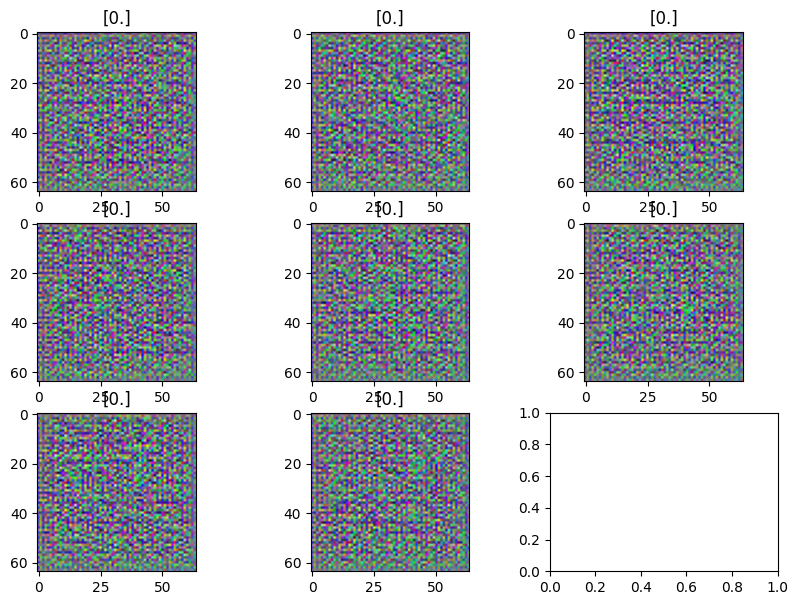

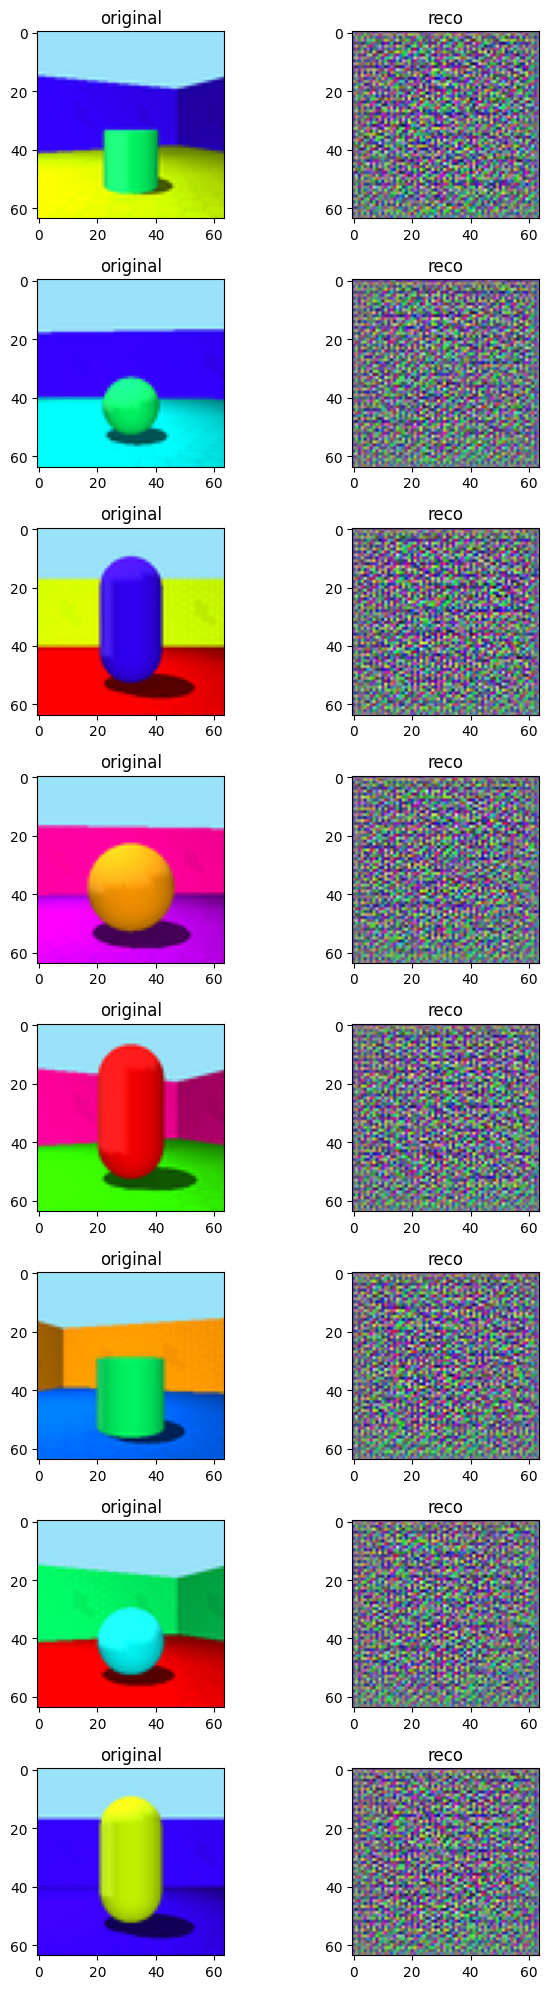

: 

In [ ]:
beta=1
vae = VAEModule(in_channels=in_channels, img_size=img_size, latent_dim=LATENT_DIM, beta=beta, kl_weights=0.00001,  res_block=ResidualBlock)
image_hat_logits = vae(images)
print(f"Sanity check : {image_hat_logits[0].shape}")
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

In [ ]:
max_epoch=80
trainer = Trainer(
        accelerator="auto",
        devices=[0],
        max_epochs=max_epoch,

        logger=TensorBoardLogger(
            save_dir=PROJECT_PATH+"disdiff_adapters/notebook/",
            version="cur",
            default_hp_metric=False,
            )
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


: 

/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOB

Epoch 0:   0%|          | 0/19 [00:00<?, ?it/s] Train loss: 0.11473283171653748
Train loss: 0.11108699440956116
Train loss: 0.11537649482488632
Train loss: 0.11364511400461197
Epoch 0:   5%|▌         | 1/19 [00:01<00:19,  0.92it/s, v_num=cur]Train loss: 0.1105819046497345
Train loss: 0.10911596566438675Train loss: 0.10944872349500656
Train loss: 0.11078640818595886

Epoch 0:  11%|█         | 2/19 [00:01<00:09,  1.80it/s, v_num=cur]Train loss: 0.10926099866628647
Train loss: 0.10674379765987396
Train loss: 0.10898993164300919
Train loss: 0.10813870280981064
Epoch 0:  16%|█▌        | 3/19 [00:01<00:06,  2.65it/s, v_num=cur]Train loss: 0.10527961701154709
Train loss: 0.10658595710992813
Train loss: 0.10493458807468414
Train loss: 0.10565973818302155
Epoch 0:  21%|██        | 4/19 [00:01<00:04,  3.47it/s, v_num=cur]Train loss: 0.10669916123151779Train loss: 0.10071327537298203Train loss: 0.10407108813524246


Train loss: 0.10207541286945343
Epoch 0:  26%|██▋       | 5/19 [00:01<00:03,  4.2

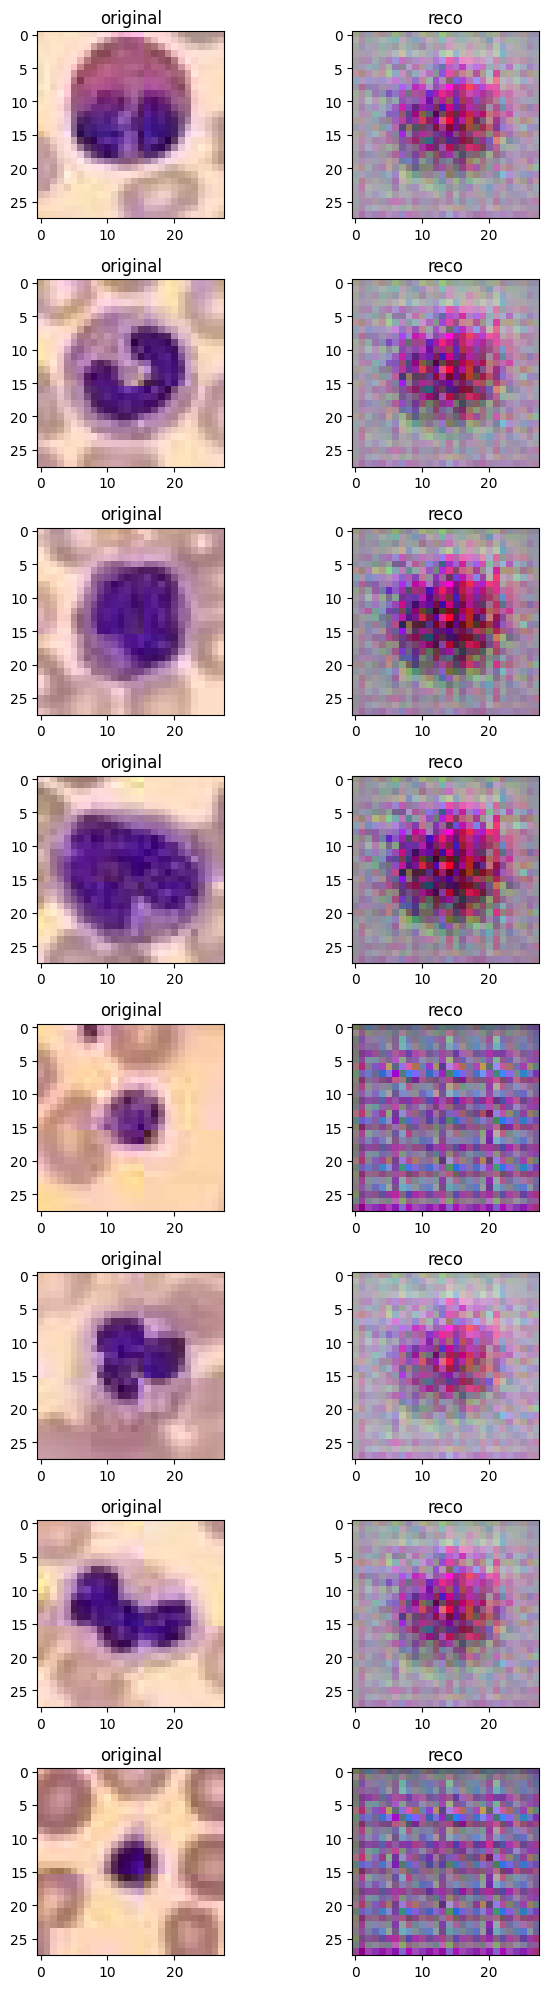

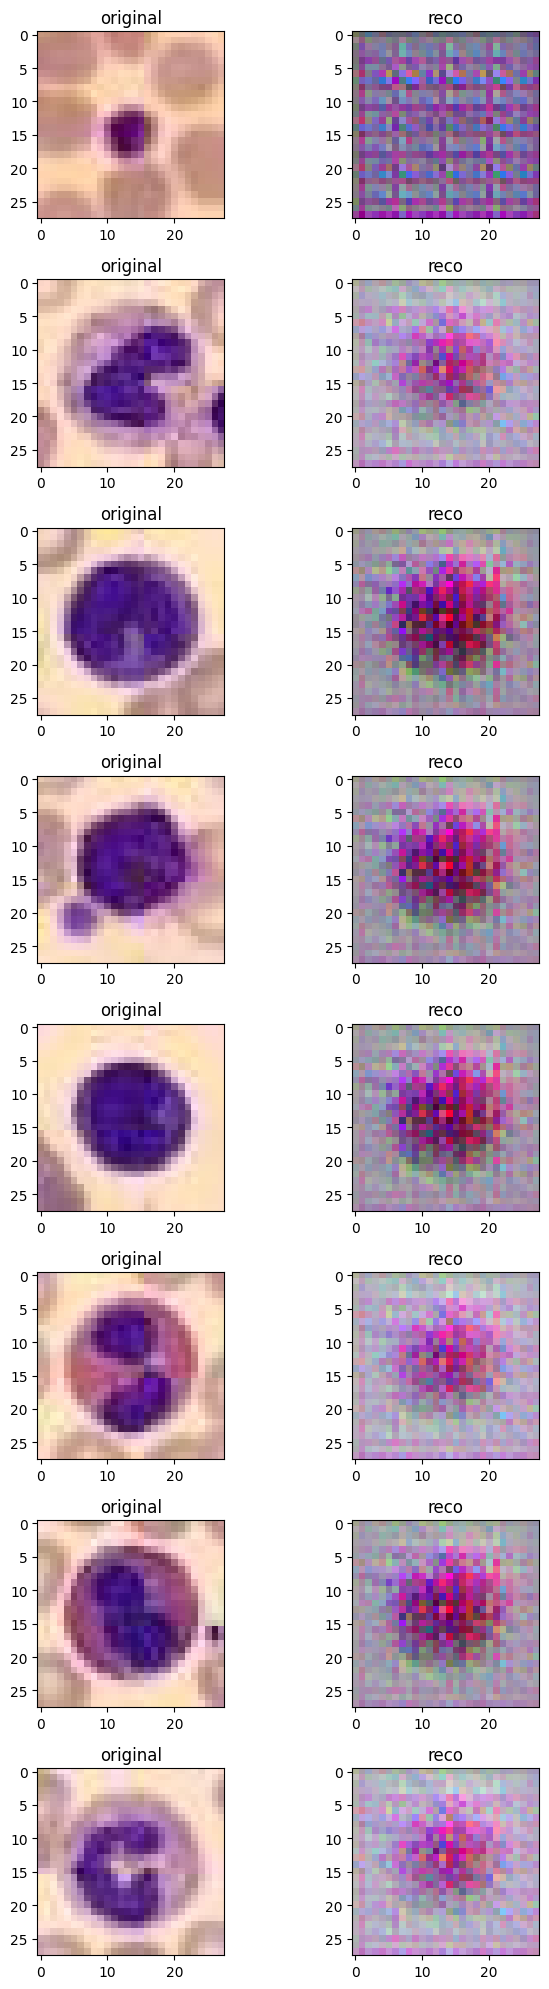

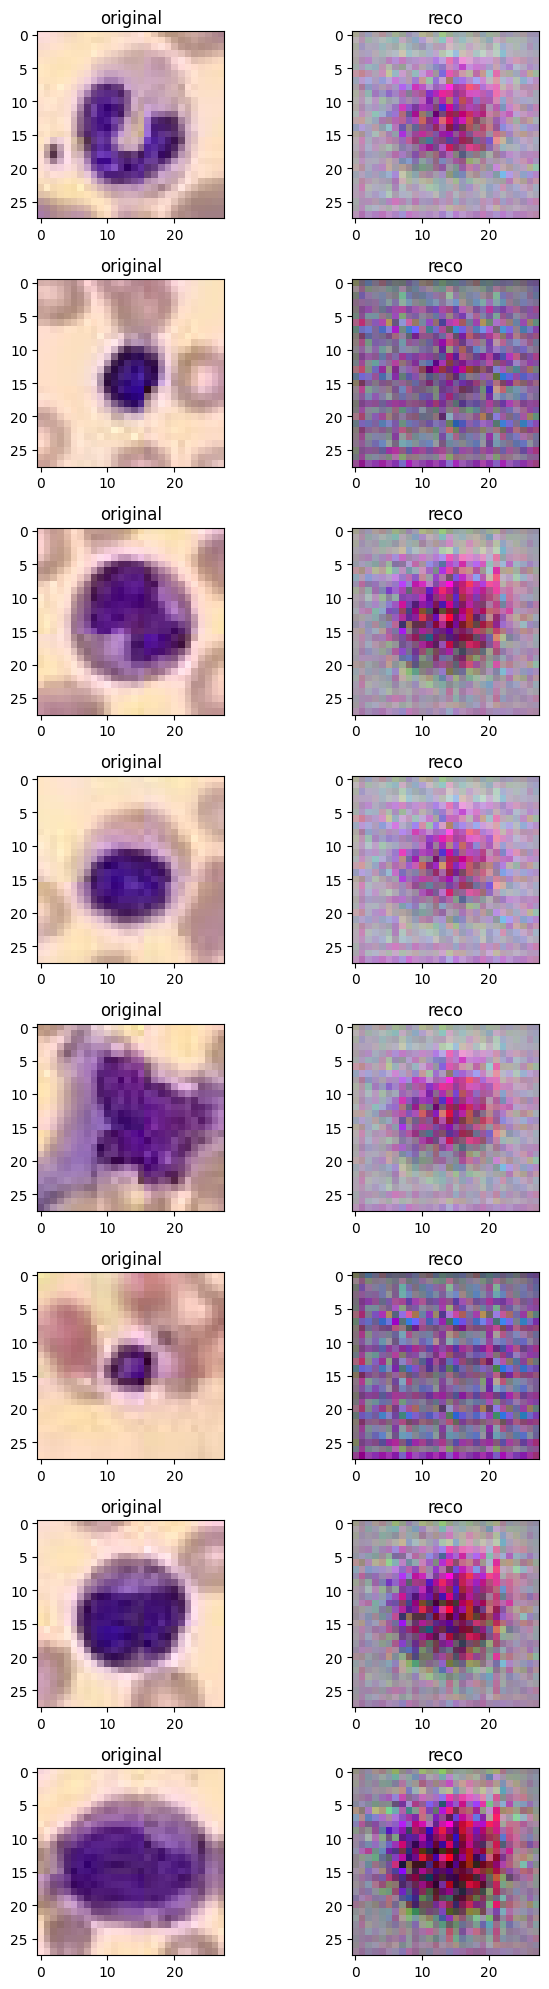

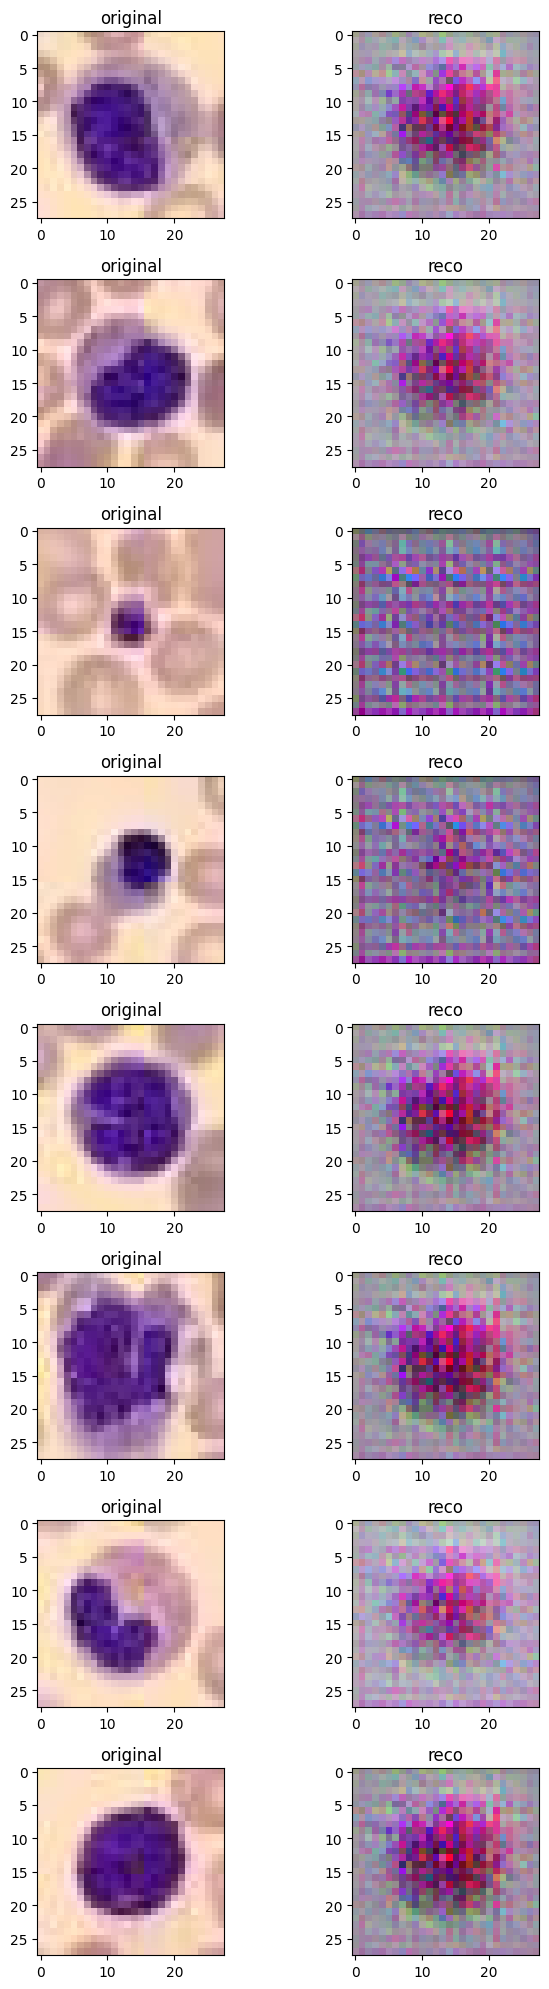

Epoch 1:   5%|▌         | 1/19 [00:09<02:52,  0.10it/s, v_num=cur]Train loss: 0.08195357024669647
Train loss: 0.08157747238874435
Train loss: 0.08263475447893143
Train loss: 0.08220312744379044Train loss: 0.08076339960098267Train loss: 0.07998181879520416


Train loss: 0.08256271481513977
Epoch 1:  11%|█         | 2/19 [00:11<01:41,  0.17it/s, v_num=cur]Train loss: 0.07884391397237778Train loss: 0.07901779562234879Train loss: 0.08043046295642853


Train loss: 0.07885810732841492
Epoch 1:  21%|██        | 4/19 [00:12<00:45,  0.33it/s, v_num=cur]Train loss: 0.07952075451612473Train loss: 0.07643678039312363

Train loss: 0.07699446380138397
Train loss: 0.08127106726169586
Train loss: 0.08147653192281723
Train loss: 0.07665937393903732
Epoch 1:  26%|██▋       | 5/19 [00:12<00:33,  0.41it/s, v_num=cur]
Train loss: 0.0769038051366806
Epoch 1:  32%|███▏      | 6/19 [00:12<00:26,  0.50it/s, v_num=cur]Train loss: 0.07769912481307983
Train loss: 0.07822271436452866
Train loss: 0.0791163519024849

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

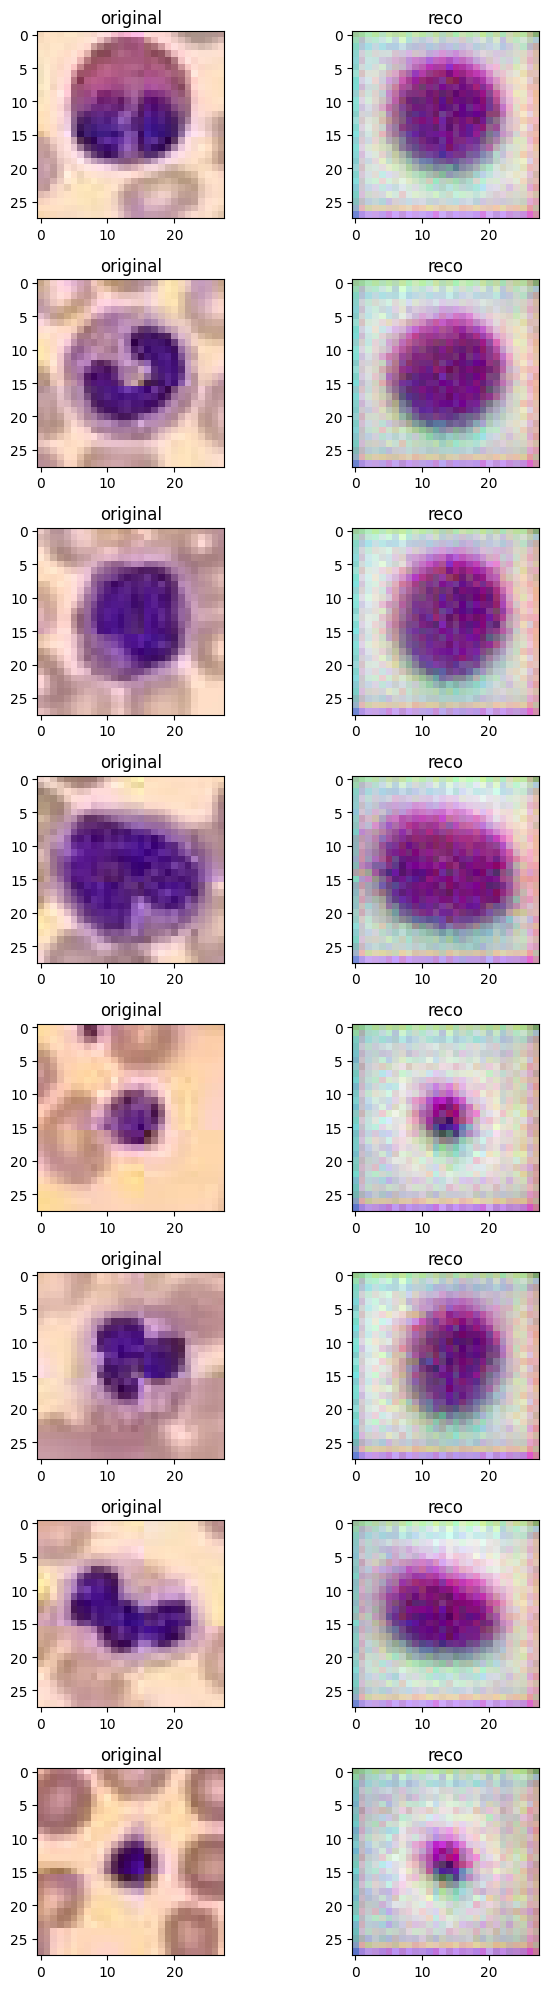

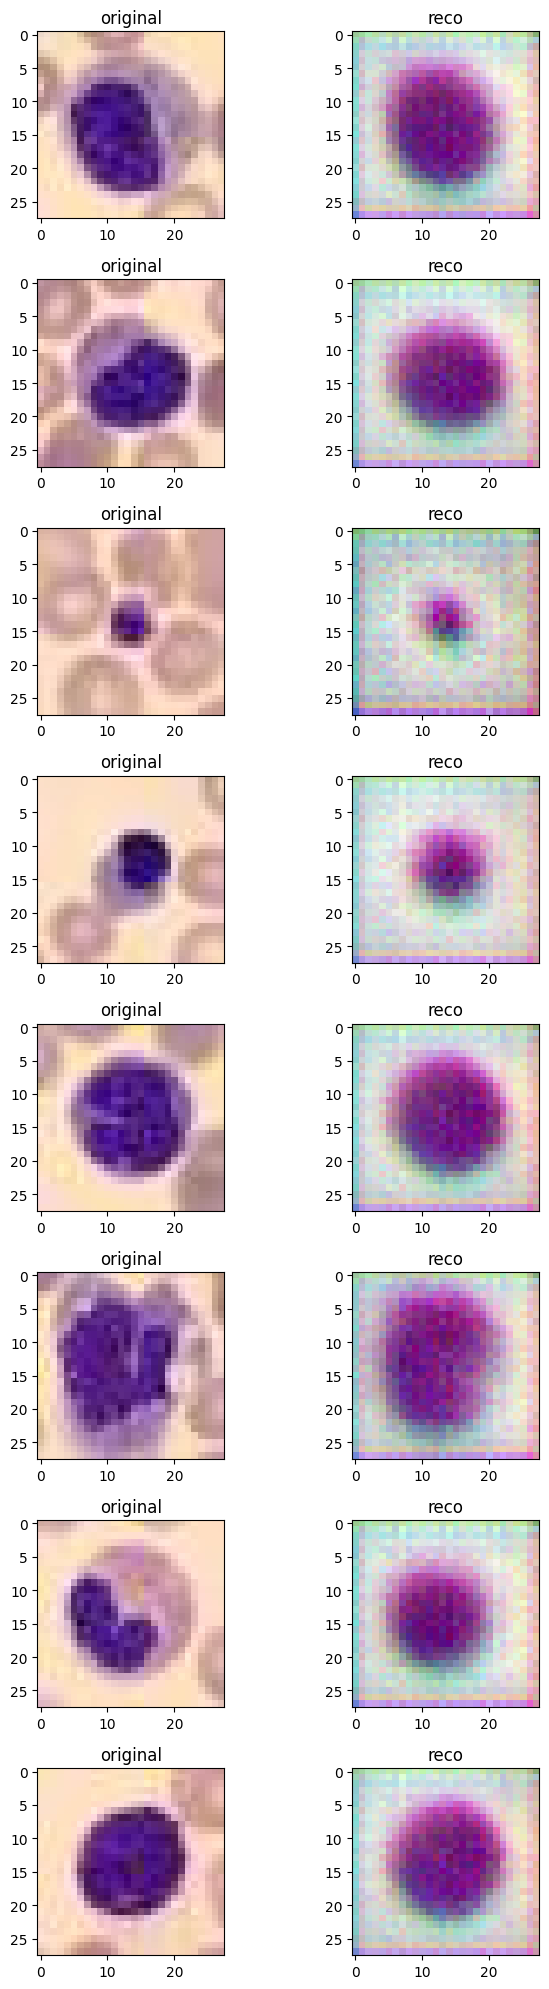

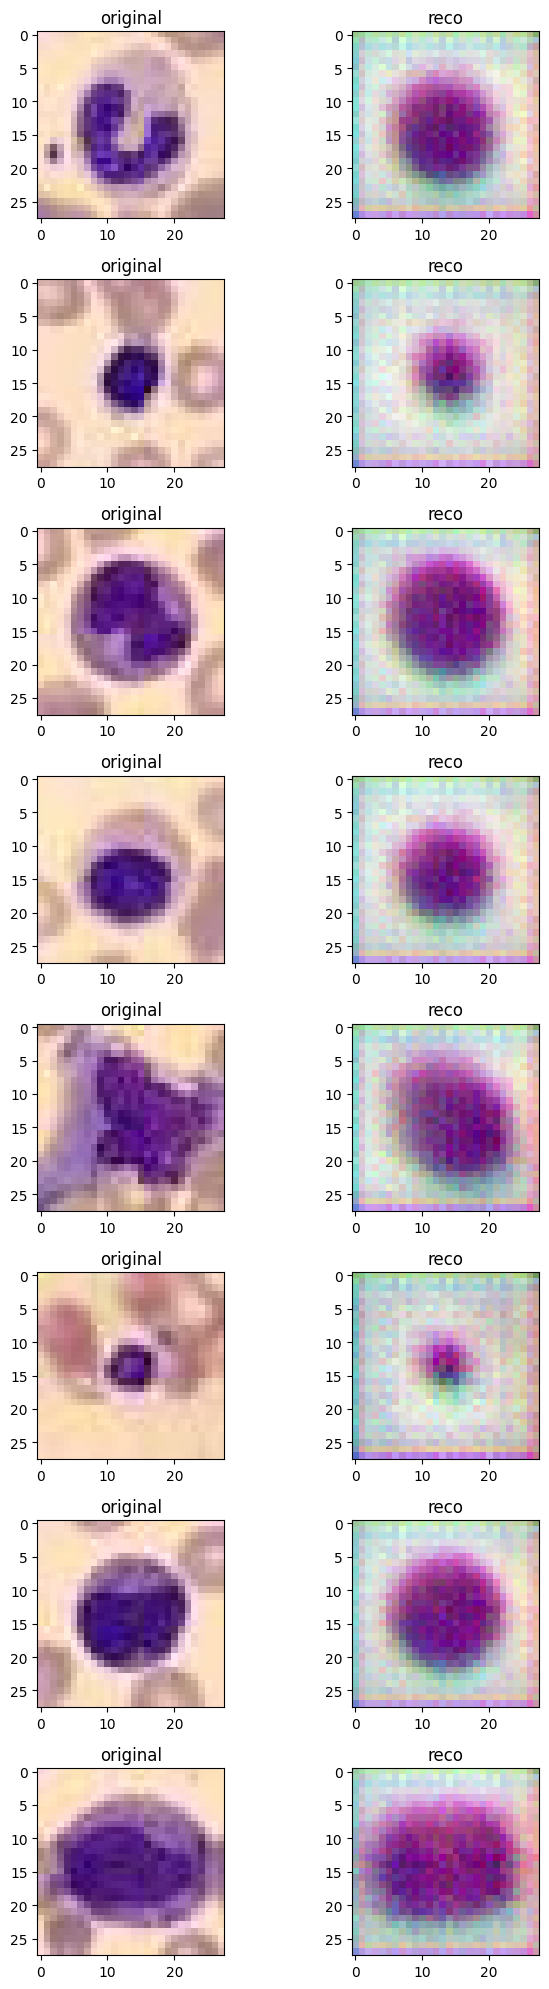

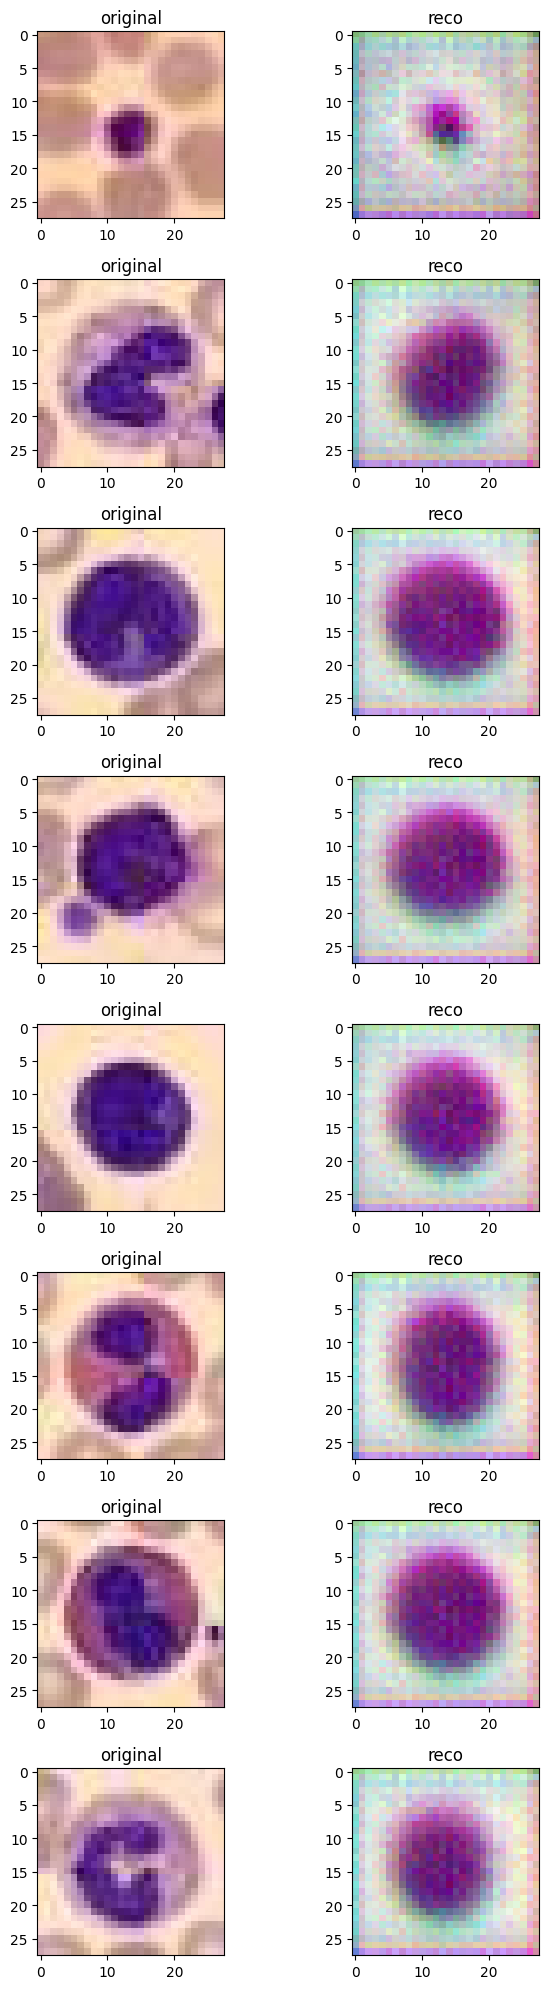

Epoch 11:   5%|▌         | 1/19 [00:12<03:41,  0.08it/s, v_num=cur]Train loss: 0.02332492731511593Train loss: 0.023285040631890297
Train loss: 0.02320476993918419

Train loss: 0.02329019457101822
Train loss: 0.023286767303943634Train loss: 0.023296890780329704

Train loss: 0.022798022255301476
Epoch 11:  11%|█         | 2/19 [00:14<02:04,  0.14it/s, v_num=cur]Train loss: 0.02280602604150772
Train loss: 0.022467290982604027
Epoch 11:  16%|█▌        | 3/19 [00:14<01:18,  0.20it/s, v_num=cur]Train loss: 0.022896872833371162
Train loss: 0.022969713434576988
Train loss: 0.02302381582558155Train loss: 0.02275770530104637
Train loss: 0.022568680346012115

Train loss: 0.022345243021845818
Epoch 11:  21%|██        | 4/19 [00:14<00:55,  0.27it/s, v_num=cur]Train loss: 0.02297995425760746Train loss: 0.02324994094669819

Train loss: 0.02241908758878708
Train loss: 0.022641483694314957
Epoch 11:  26%|██▋       | 5/19 [00:14<00:41,  0.34it/s, v_num=cur]Train loss: 0.022350236773490906Train loss: 0.0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

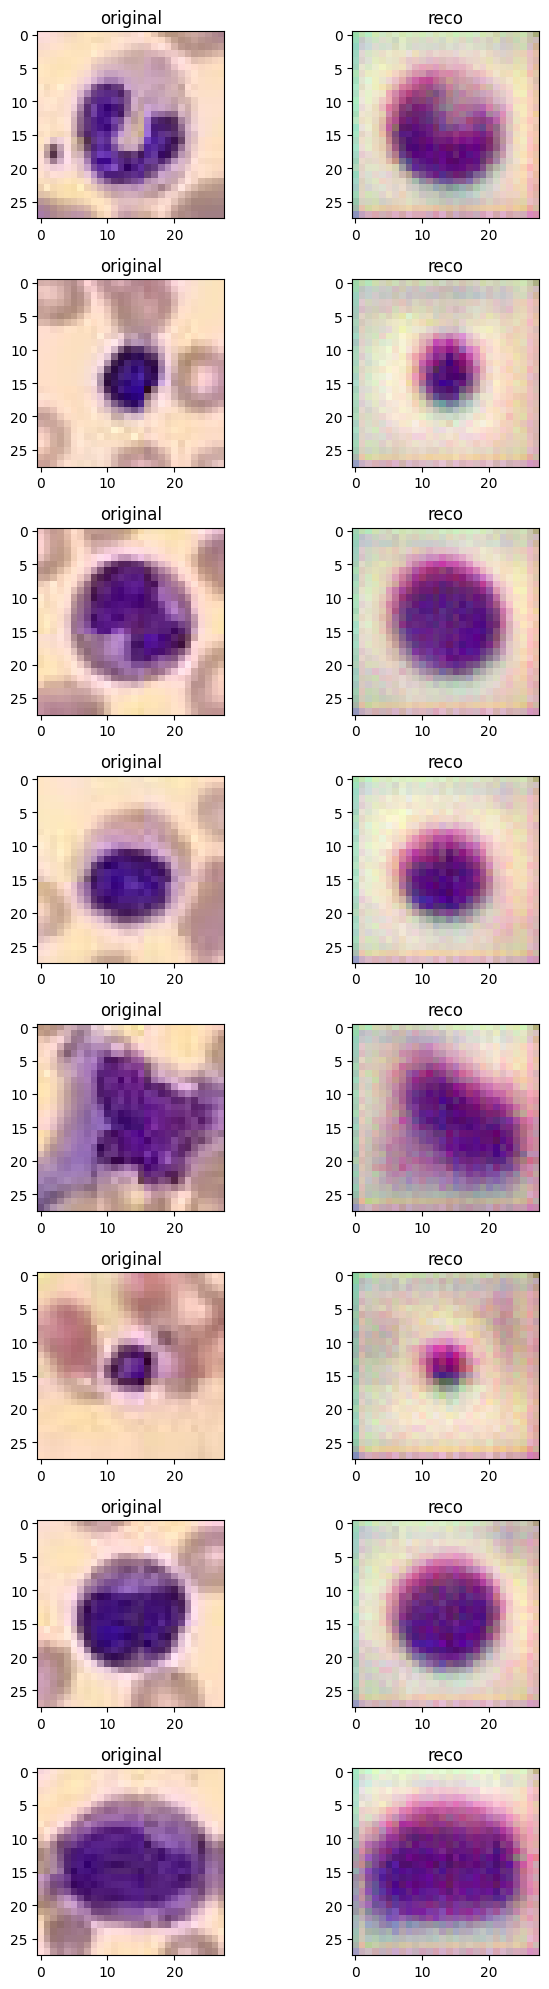

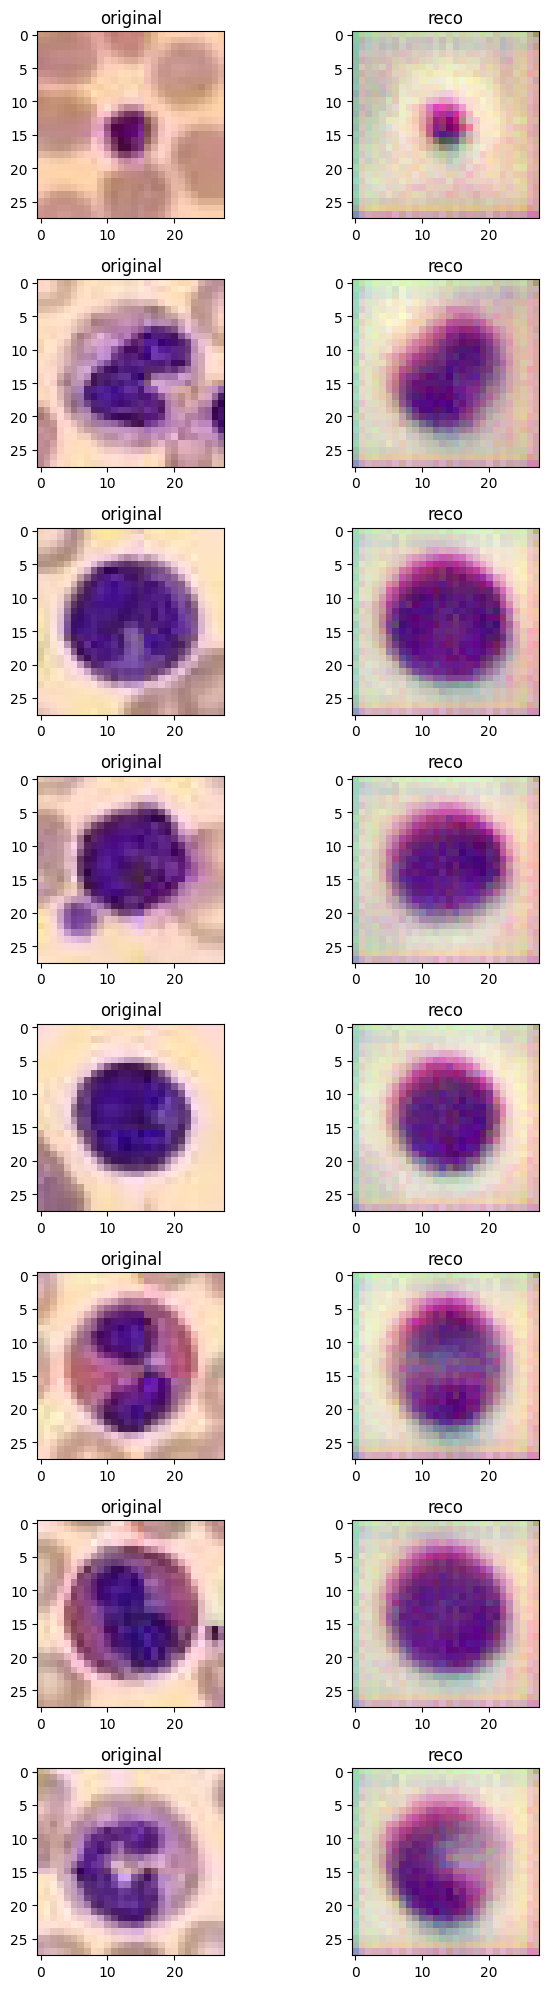

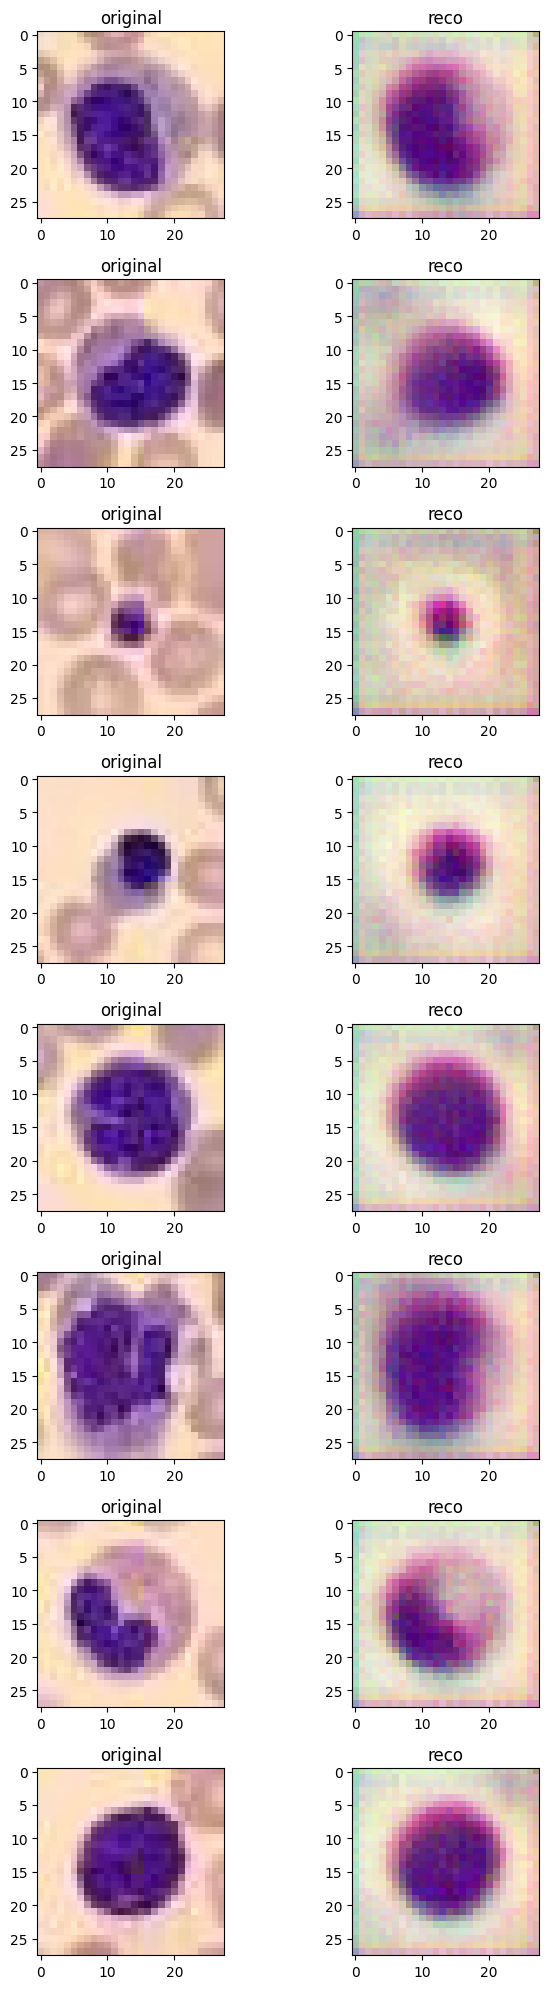

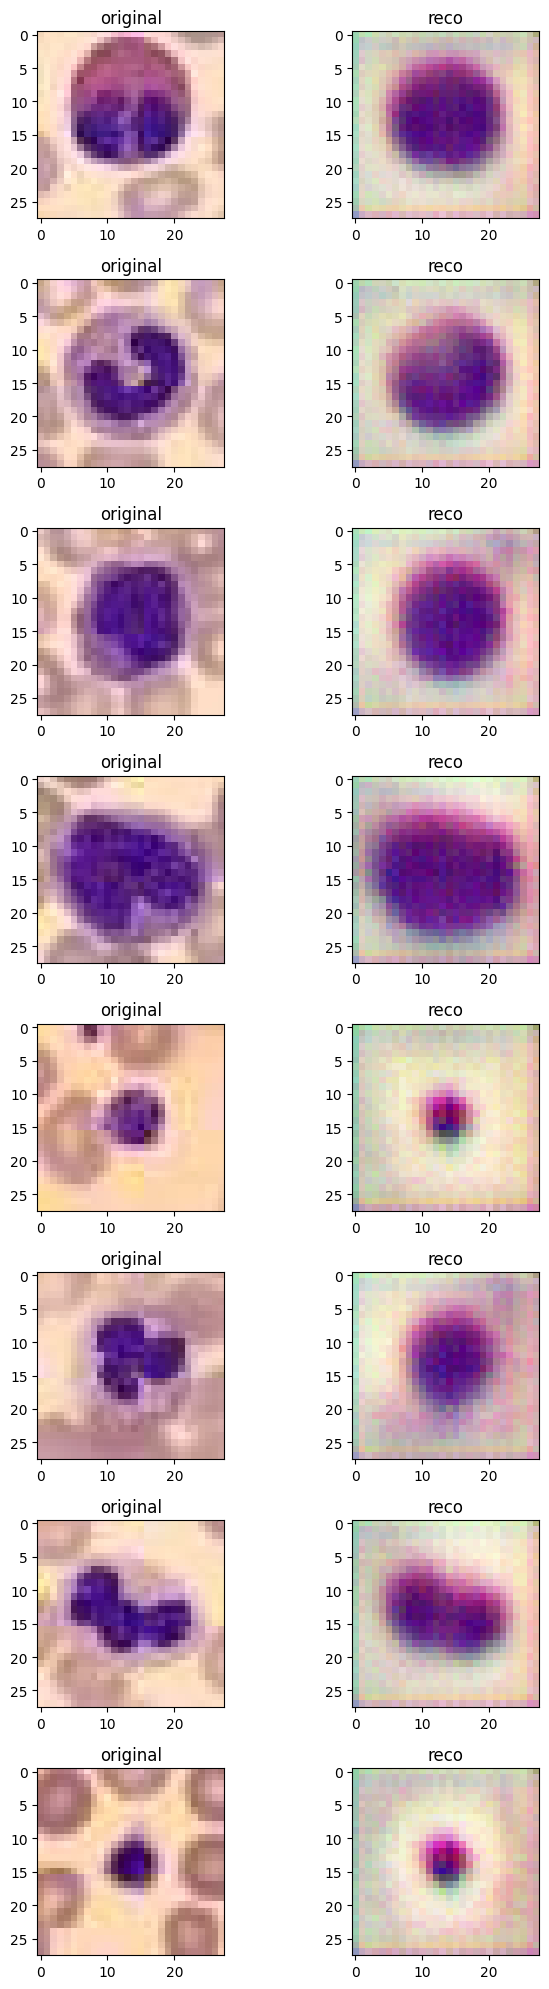

Epoch 21:   0%|          | 0/19 [00:00<?, ?it/s, v_num=cur]         

: 

In [ ]:
trainer.fit(vae, loader)

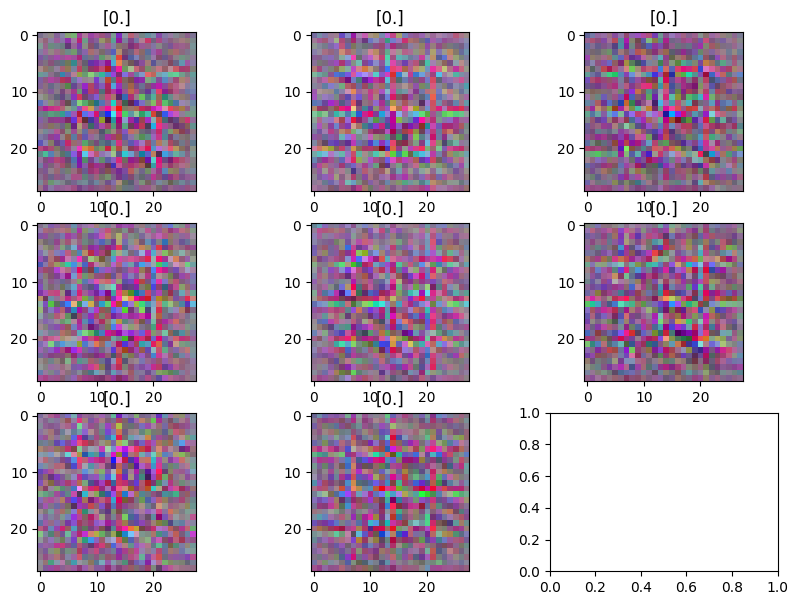

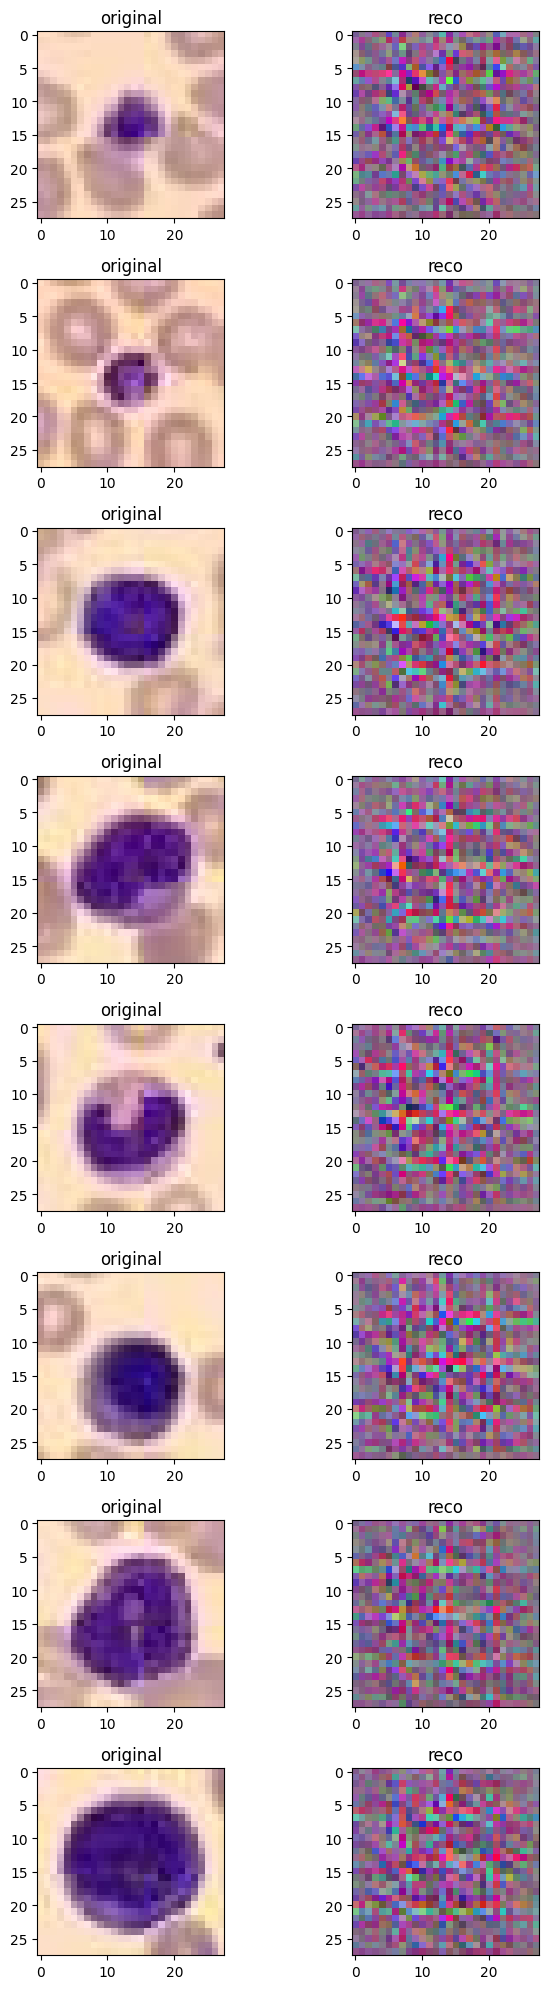

: 

In [ ]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

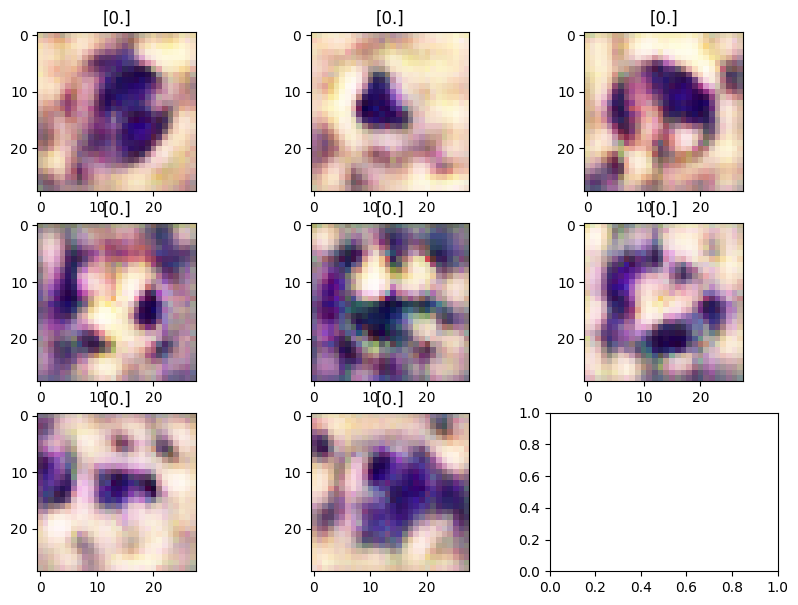

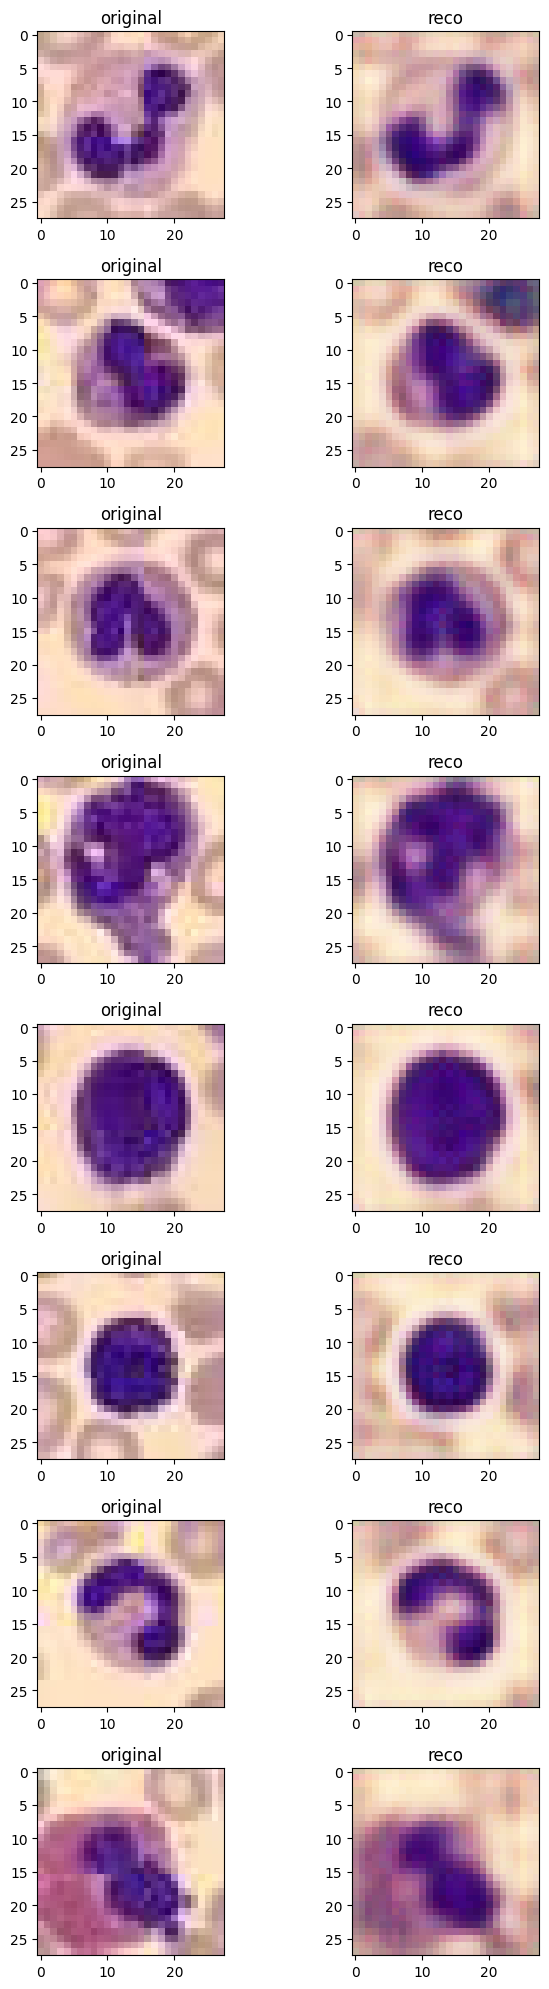

: 

: 

In [ ]:
gen_images = vae.generate(8)
display((gen_images, torch.zeros([8,1])))
vae.show_reconstruct(images[:8])

#### [DEBUG VAE]

##### Test - loss

In [ ]:
#kl test
mu = torch.tensor([[0,0,0,0]])
logvar = torch.tensor([[0, 0, 0, 0]])
kl_loss = kl(mu, logvar)
assert abs(kl_loss - 0.0) < 10e-3, "Error in kl implementation"
print(f"kl ok. kl={kl_loss}")

#mse test
k=2
images_hat_logits = torch.zeros([1, 3, 28, 28])
images = k*torch.ones([1, 3, 28, 28])
mse_loss = mse(images_hat_logits, images)
assert abs(mse_loss-k**2) < 10e-3
print(f"mse ok. mse={mse_loss}")

kl ok. kl=0.0
mse ok. mse=4.0


: 

In [ ]:
test = torch.load("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/bloodmnist/bloodmnist_test.pt")

: 

In [ ]:
test[0].shape

torch.Size([3421, 3, 28, 28])

: 

##### Auto Encoder (VAE without sampling and only reco loss)

In [ ]:
ae = AEModule.load_from_checkpoint("disdiff_adapters/logs/ae/shapes/ae_epoch=10_beta=1.0_latent=128/checkpoints/epoch=9-step=384000.ckpt")

: 

In [ ]:
ae.show_reconstruct(images)

NameError: name 'ae' is not defined

: 

## Multi-Distillme

#### Train

From "load data" images.shape=torch.Size([128, 3, 64, 64])


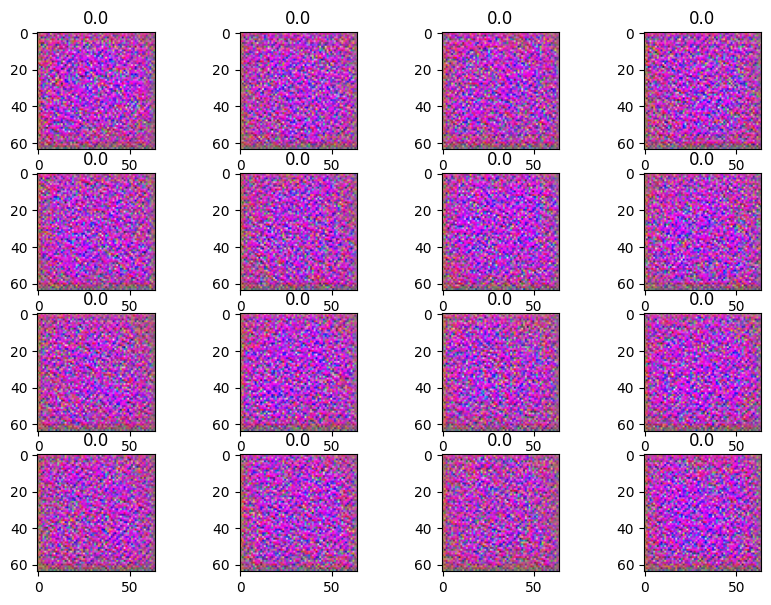

In [7]:
multi_dm = MultiDistillMeModule(in_channels=in_channels, img_size=img_size, latent_dim_s=LATENT_DIM, latent_dim_t=LATENT_DIM, res_block=ResidualBlock)
print(f"From \"load data\" images.shape={images.shape}")

display((multi_dm.generate(), torch.zeros(BATCH_SIZE)))

In [8]:
max_epoch=2
trainer = Trainer(
        accelerator="auto",
        devices=[0],
        max_epochs=max_epoch,

        logger=TensorBoardLogger(
            save_dir=PROJECT_PATH+"disdiff_adapters/notebook/",
            version="cur",
            default_hp_metric=False,
            )
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/projects/compures/alexandre/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | _MultiDistillMe | 11.9 M | train
--------------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.447    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2400/2400 [01:45<00:00, 22.74it/s, v_num=cur]

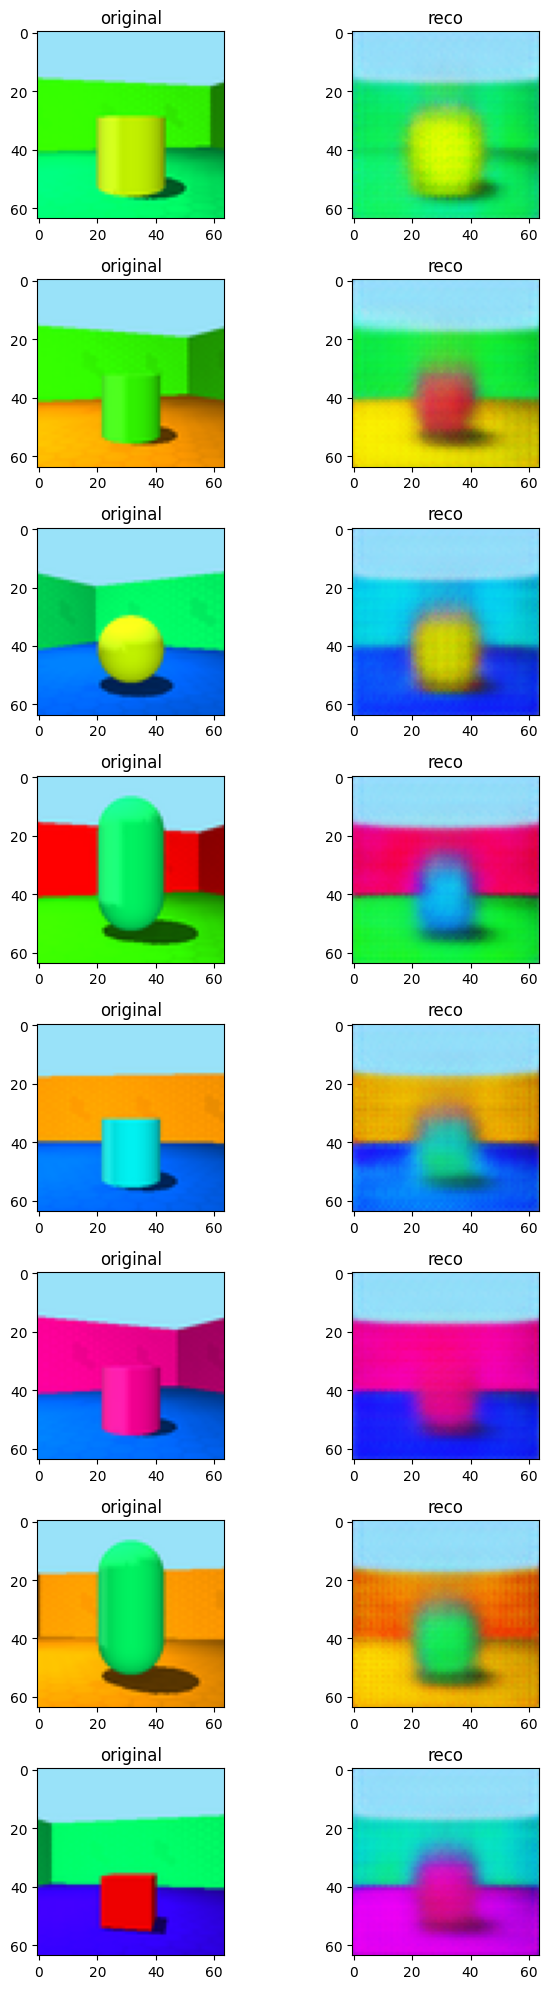

Epoch 1: 100%|██████████| 2400/2400 [01:51<00:00, 21.56it/s, v_num=cur]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 2400/2400 [01:51<00:00, 21.44it/s, v_num=cur]


<Figure size 640x480 with 0 Axes>

In [9]:
trainer.fit(multi_dm, loader)

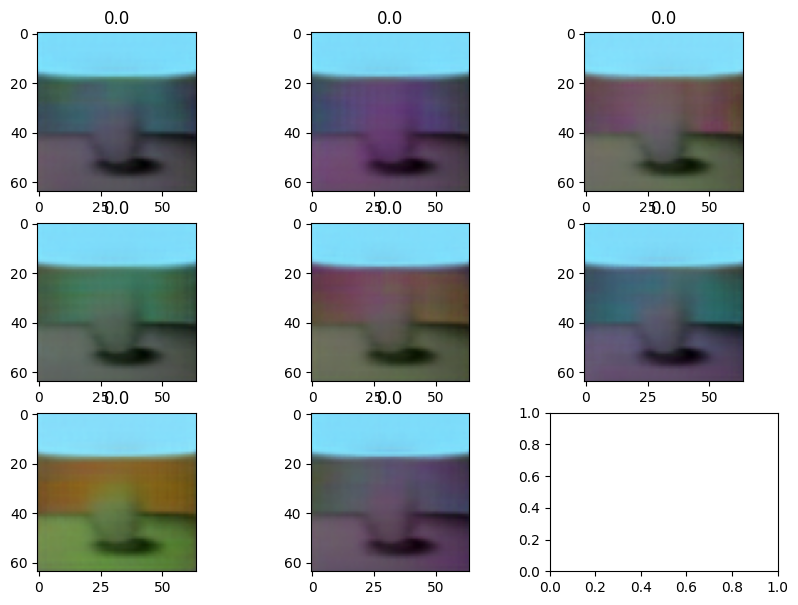

: 

In [ ]:
display((multi_dm.generate(), torch.zeros(BATCH_SIZE)))

#### Test

In [6]:
from lightning import LightningModule
def show_reconstruct(lm: MultiDistillMeModule, images: torch.Tensor) :
    images = images.to(lm.device)[:8]
    _,_, images_gen, *_ = lm(images, test=True)

    fig, axes = plt.subplots(len(images), 2, figsize=(7, 20))

    for i in range(len(images)) :
        img = images[i]
        img_gen = images_gen[i]

        images_proc = (255*((img - img.min()) / (img.max() - img.min() + 1e-8))).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()
        images_gen_proc = (255*((img_gen - img_gen.min()) / (img_gen.max() - img_gen.min() + 1e-8))).to("cpu",torch.uint8).permute(1,2,0).detach().numpy()

        axes[i,0].imshow(images_proc)
        axes[i,1].imshow(images_gen_proc)

        axes[i,0].set_title("original")
        axes[i,1].set_title("reco")
    plt.tight_layout()
    plt.show()

In [ ]:
lm = MultiDistillMeModule.load_from_checkpoint("/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/logs/md/celeba/md_epoch=50_beta=(1.0, 1.0)_latent=(64, 64)_batch=32_warm_up=True_lr=1e-05_arch=res/checkpoints/epoch=45-step=234002.ckpt")

: 

In [ ]:
celeba.setup(stage='test')
celeba_test = celeba.test_dataloader()
batch = next(iter(celeba_test))
images, labels = batch
display((lm.generate().cpu(), torch.zeros(8)))
show_reconstruct(lm, images)

: 